In [39]:
import grid2op
import numpy as np
from lightsim2grid import LightSimBackend
from grid2op.Parameters import Parameters
from superposition_theorem import *
param = Parameters()
param.ENV_DC = True
param.MAX_LINE_STATUS_CHANGED = 99999
param.MAX_SUB_CHANGED = 99999
backend=LightSimBackend()
env = grid2op.make("l2rpn_case14_sandbox", param=param,backend=backend)


/home/marotant/dev/Topology_Superposition_Theorem/venv_sup_theorem/lib/python3.8/site-packages/lightsim2grid/gridmodel/_aux_add_trafo.py:33: UserWarning: There were some Nan in the pp_net.trafo["tap_neutral"], they have been replaced by 0
  warnings.warn("There were some Nan in the pp_net.trafo[\"tap_neutral\"], they have been replaced by 0")
/home/marotant/dev/Topology_Superposition_Theorem/venv_sup_theorem/lib/python3.8/site-packages/lightsim2grid/gridmodel/_aux_add_trafo.py:41: UserWarning: There were some Nan in the pp_net.trafo["tap_step_percent"], they have been replaced by 0
  warnings.warn("There were some Nan in the pp_net.trafo[\"tap_step_percent\"], they have been replaced by 0")
/home/marotant/dev/Topology_Superposition_Theorem/venv_sup_theorem/lib/python3.8/site-packages/lightsim2grid/gridmodel/_aux_add_trafo.py:46: UserWarning: There were some Nan in the pp_net.trafo["tap_pos"], they have been replaced by 0
  warnings.warn("There were some Nan in the pp_net.trafo[\"tap_po

# compute the A matrix that defines the delta

$$\delta_{i,j} = \frac{F_j^{i} - F_j}{F_i}$$

with:
- $\delta_{i,j}$ : "le coefficient de report"
- $F_k$: the active flow on line `k`
- $F_j^{i}$: the flow on line j if the line i is disconnected

We are interested, given all the $\delta_{i,j}$ to compute the $\delta_{\{i,j,k, ...\}, m}$ which are the flows on line `m` when the lines $\{i,j,k, ...\}$ are disconnected

In [2]:
_ = env.reset()
#with env.copy() as tmp_env_init:
init_obs, *_ = env.simulate(env.action_space())
F = 1. * init_obs.p_or

In [3]:
init_obs

In [4]:
all_flows = np.zeros((env.n_line, env.n_line))
for l_id in range(env.n_line):
    #with env.copy() as tmp_env:
    obs, *_ = env.simulate(env.action_space({"set_line_status": [(l_id, -1)]}))
    all_flows[l_id, :] = obs.p_or

In [5]:
A = (all_flows - F) / F.reshape(-1, 1)

/tmp/ipykernel_51711/3487405670.py:1: RuntimeWarning: divide by zero encountered in true_divide
  A = (all_flows - F) / F.reshape(-1, 1)
/tmp/ipykernel_51711/3487405670.py:1: RuntimeWarning: invalid value encountered in true_divide
  A = (all_flows - F) / F.reshape(-1, 1)


In [6]:
F

array([ 38.58359  ,  37.61641  ,  22.565678 ,  41.696144 ,  35.121765 ,
        16.86568  , -29.562853 ,   6.4211507,   7.0682087,  16.285961 ,
         5.7788496,   9.545831 ,  -3.0211506,   1.5682089,   5.2541695,
        27.484486 ,  16.040195 ,  36.275322 ,   0.       , -27.484486 ],
      dtype=float32)

In [7]:
A[3][3]

-1.0

In [8]:
init_obs.p_or[2] + A[1, 2] * init_obs.p_or[1]

28.917064666748047

In [9]:
all_flows[1, 2]

28.917064666748047

In [10]:
all_flows[1]

array([ 76.19999695,   0.        ,  28.91706467,  54.98823929,
        53.09469223,  23.21706772, -11.00502491,   5.76739502,
         6.9721899 ,  15.95008183,   6.43260527,   9.9777298 ,
        -2.36739492,   1.47218966,   4.82227087,  28.17004204,
        16.44029236,  35.18966675,   0.        , -28.17004204])

In [11]:
env.name_line

array(['0_1_0', '0_4_1', '1_2_2', '1_3_3', '1_4_4', '2_3_5', '3_4_6',
       '5_10_7', '5_11_8', '5_12_9', '8_9_10', '8_13_11', '9_10_12',
       '11_12_13', '12_13_14', '3_6_15', '3_8_16', '4_5_17', '6_7_18',
       '6_8_19'], dtype='<U8')

/tmp/ipykernel_51711/1743600663.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


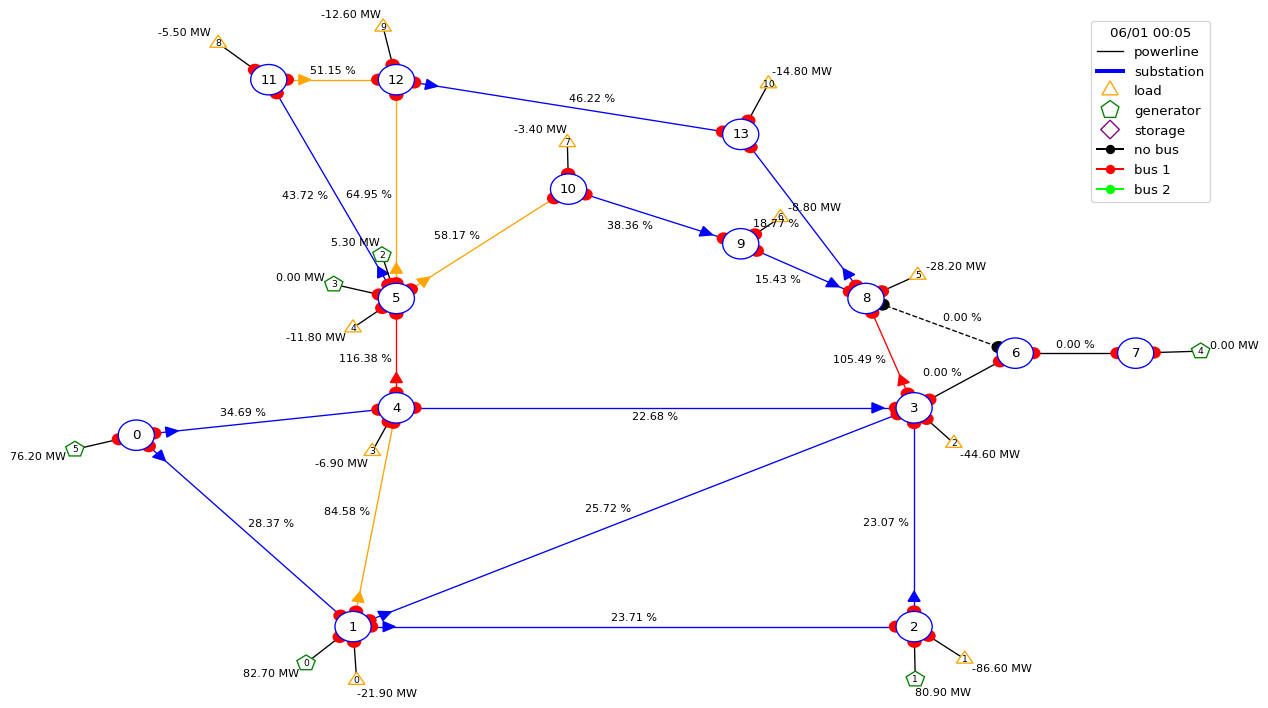

In [12]:
from grid2op.PlotGrid import PlotMatplot
plot_helper = PlotMatplot(env.observation_space)
fig = plot_helper.plot_obs(obs)
fig.show()


In [13]:
id_l1=3
id_l2=7
#with env.copy() as tmp_env:
obs_disconnected_l1_l2, *_ = env.simulate(env.action_space({"set_line_status": [(id_l1, -1),(id_l2, -1)]}))

In [14]:
obs_disconnect_l1, *_ = env.simulate(env.action_space({"set_line_status": [(id_l1, -1)]}))

In [15]:
obs_disconnect_l2, *_ = env.simulate(env.action_space({"set_line_status": [(id_l2, -1)]}))

/tmp/ipykernel_51711/2960431092.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


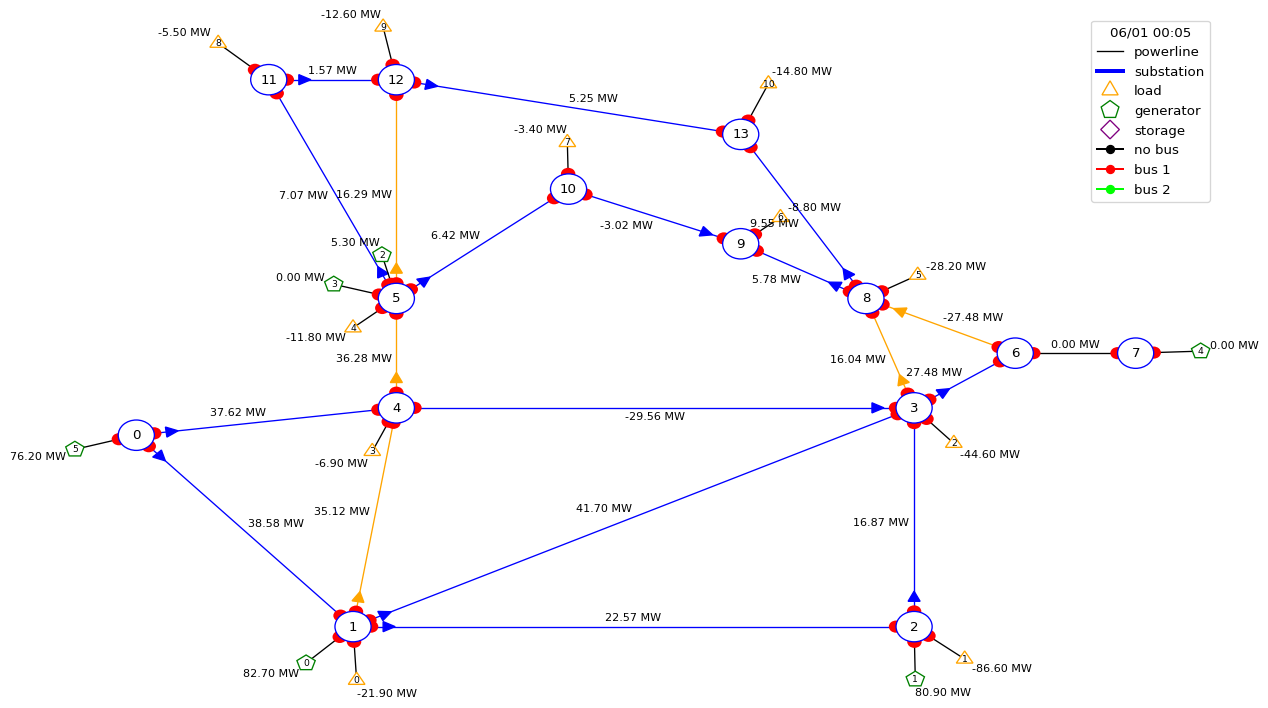

In [16]:
plot_helper = PlotMatplot(env.observation_space)
fig = plot_helper.plot_obs(init_obs,line_info='p')
fig.show()

/tmp/ipykernel_51711/1221570596.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


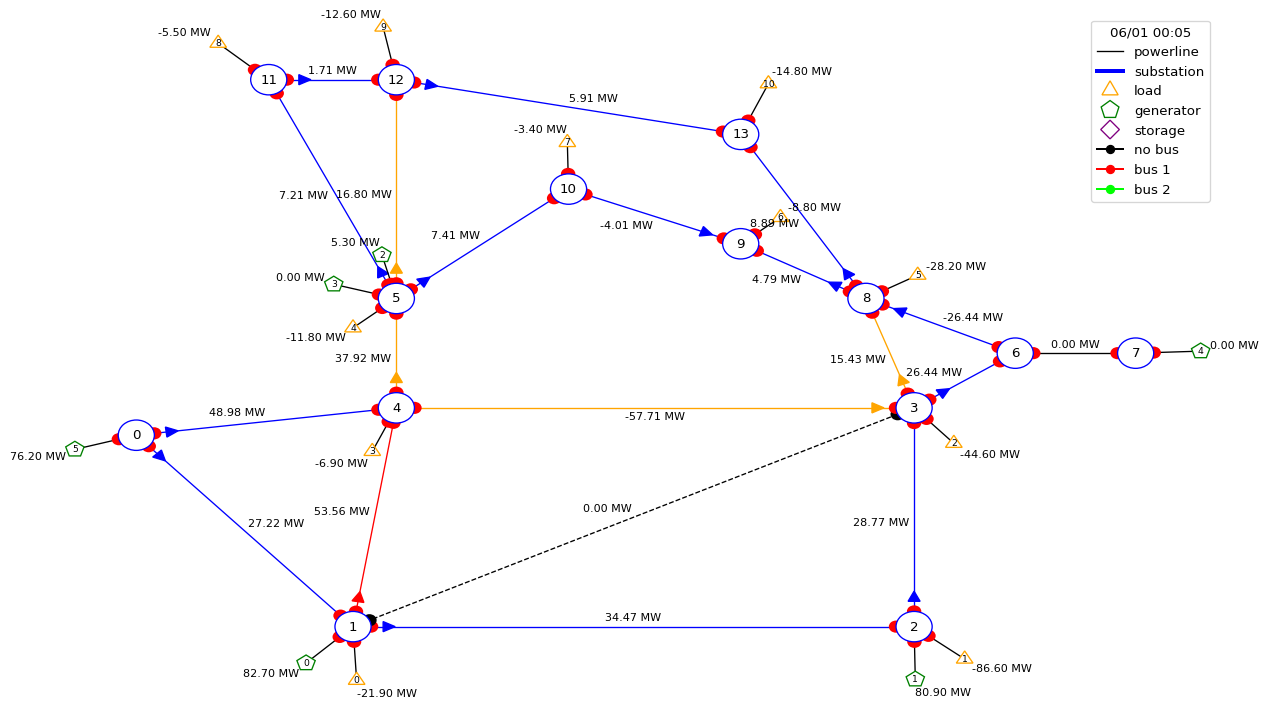

In [17]:
plot_helper = PlotMatplot(env.observation_space)
fig = plot_helper.plot_obs(obs_disconnect_l1,line_info='p')
fig.show()

/tmp/ipykernel_51711/2701937532.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


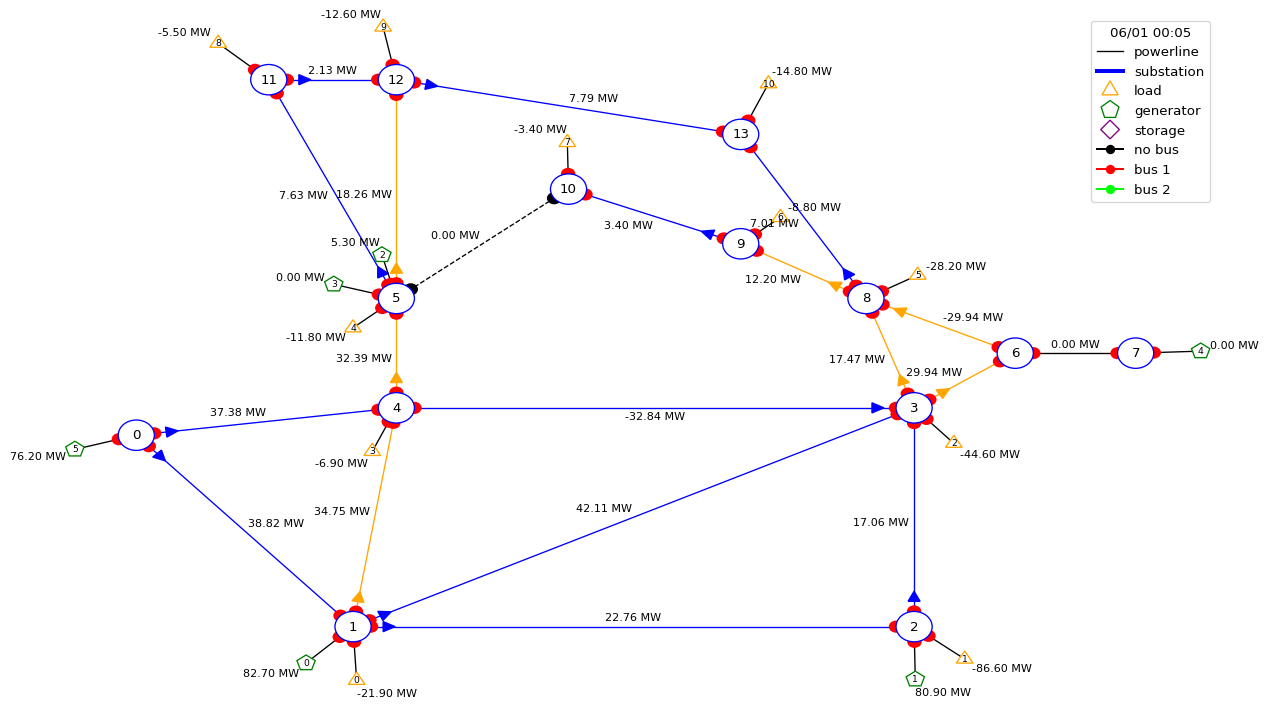

In [18]:
plot_helper = PlotMatplot(env.observation_space)
fig = plot_helper.plot_obs(obs_disconnect_l2,line_info='p')
fig.show()

/tmp/ipykernel_51711/949627794.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


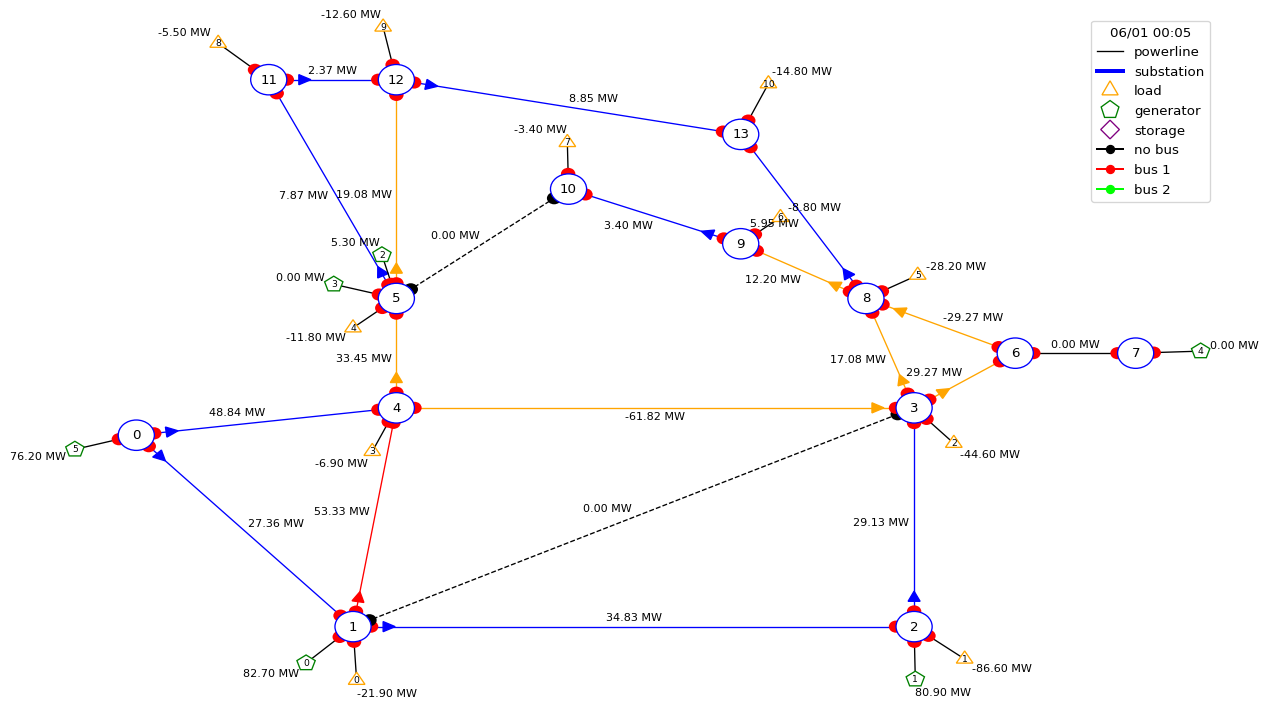

In [19]:
plot_helper = PlotMatplot(env.observation_space)
fig = plot_helper.plot_obs(obs_disconnected_l1_l2,line_info='p')
fig.show()

In [20]:
init_obs, *_ = env.simulate(env.action_space())
delta_P_l1_disconnected=obs_disconnect_l1.p_or.copy()-init_obs.p_or.copy()
delta_P_l2_disconnected=obs_disconnect_l2.p_or.copy()-init_obs.p_or.copy()
delta_P_l1_connected=obs_disconnect_l1.p_or.copy()-obs_disconnected_l1_l2.p_or.copy()
delta_P_l2_connected=obs_disconnect_l2.p_or.copy()-obs_disconnected_l1_l2.p_or.copy()

In [21]:
print(delta_P_l2_disconnected/delta_P_l1_disconnected)
print(delta_P_l1_connected/delta_P_l2_connected)

[-0.02042435 -0.02042435  0.01653502 -0.00987613 -0.02042418  0.01653502
  0.1164894  -6.4752555   3.8672056   3.8672092  -6.475255    3.8672013
 -6.4752555   3.867204    3.8672042  -2.360781   -2.3607805  -2.3607843
         nan -2.360781  ]
[-0.01209631 -0.01209631  0.03011468  0.         -0.0120963   0.03011483
  0.14190121         inf  2.774848    2.774847          -inf  2.7748454
        -inf  2.7748451   2.7748458  -4.2294097  -4.2294116  -4.2293944
         nan -4.2294097 ]


/tmp/ipykernel_51711/2954910052.py:1: RuntimeWarning: invalid value encountered in true_divide
  print(delta_P_l2_disconnected/delta_P_l1_disconnected)
/tmp/ipykernel_51711/2954910052.py:2: RuntimeWarning: divide by zero encountered in true_divide
  print(delta_P_l1_connected/delta_P_l2_connected)
/tmp/ipykernel_51711/2954910052.py:2: RuntimeWarning: invalid value encountered in true_divide
  print(delta_P_l1_connected/delta_P_l2_connected)


In [22]:
#a generic version for n-K
def get_Virtual_Flows_NPlusK(por_init,A,ilds):
    a=[]
    for idl in ilds:
        a_row=np.array([A[idlj][idl] if idl==idlj else -A[idlj][idl] for idlj in ilds])
        a.append(a_row)

    b=np.array([-p for p in por_init])
    pls_virtual=np.linalg.solve(a,b)
    print(pls_virtual)
    
    return pls_virtual

In [23]:
id_l3=0
obs_disconnected_l1_l2_l3, *_ = env.simulate(env.action_space({"set_line_status": [(id_l1, -1),(id_l2, -1),(id_l3, -1)]}))



/tmp/ipykernel_51711/3002661997.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


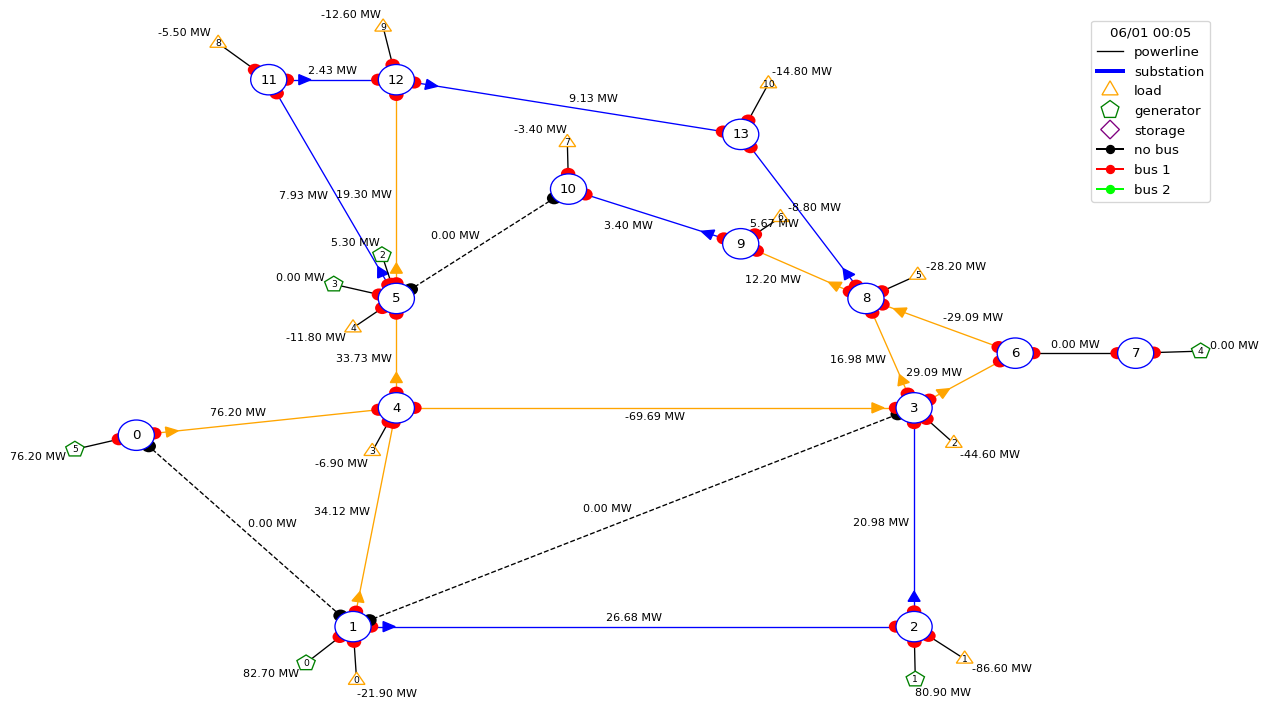

In [24]:
plot_helper = PlotMatplot(env.observation_space)
fig = plot_helper.plot_obs(obs_disconnected_l1_l2_l3,line_info='p')
fig.show()

/tmp/ipykernel_51711/4254074565.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


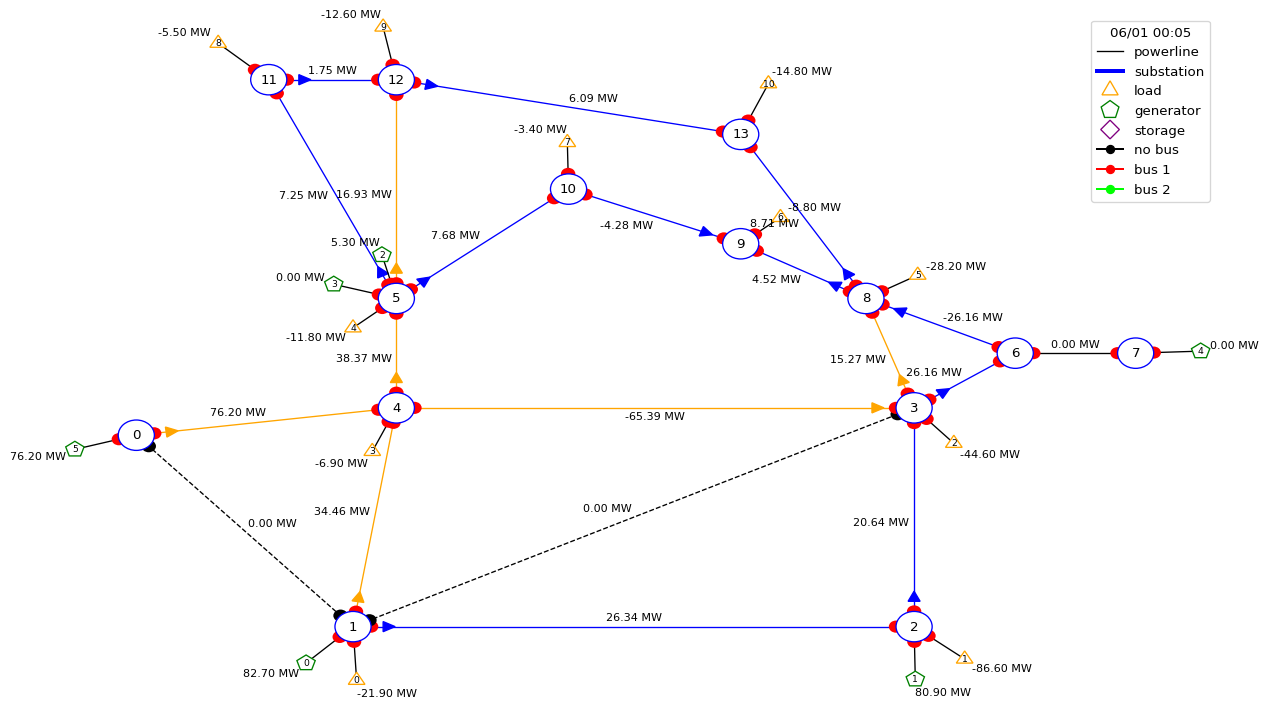

In [25]:
obs_disconnected_l1_l3, *_ = env.simulate(env.action_space({"set_line_status": [(id_l1, -1),(id_l3, -1)]}))

plot_helper = PlotMatplot(env.observation_space)
fig = plot_helper.plot_obs(obs_disconnected_l1_l3,line_info='p')
fig.show()

/tmp/ipykernel_51711/2083998006.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


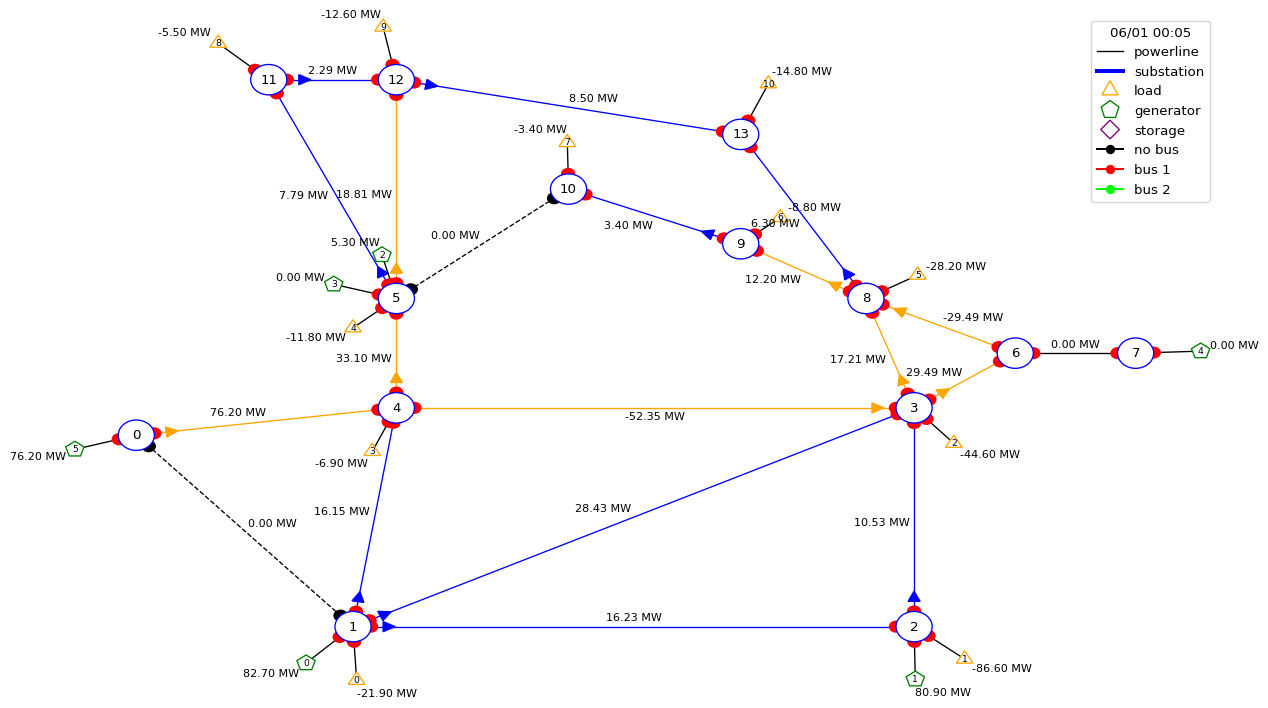

In [26]:
obs_disconnected_l2_l3, *_ = env.simulate(env.action_space({"set_line_status": [(id_l2, -1),(id_l3, -1)]}))

plot_helper = PlotMatplot(env.observation_space)
fig = plot_helper.plot_obs(obs_disconnected_l2_l3,line_info='p')
fig.show()

In [27]:
init_obs, *_ = env.simulate(env.action_space())
por_end=init_obs.p_or.copy()

obs_disconnected_l2_l3, *_ = env.simulate(env.action_space({"set_line_status": [(id_l2, -1),(id_l3, -1)]}))
por_l1_connected=obs_disconnected_l2_l3.p_or.copy()

obs_disconnected_l1_l3, *_ = env.simulate(env.action_space({"set_line_status": [(id_l1, -1),(id_l3, -1)]}))
por_l2_connected=obs_disconnected_l1_l3.p_or.copy()

obs_disconnected_l1_l2, *_ = env.simulate(env.action_space({"set_line_status": [(id_l1, -1),(id_l2, -1)]}))
por_l3_connected=obs_disconnected_l1_l2.p_or.copy()

obs_disconnected_l1_l2_l3, *_ = env.simulate(env.action_space({"set_line_status": [(id_l1, -1),(id_l2, -1),(id_l3, -1)]}))
por_l1_l2_l3=obs_disconnected_l1_l2_l3.p_or.copy()

p_init=[por_l1_connected,por_l2_connected,por_l3_connected,por_l1_l2_l3]
alpha=[]

pl1_init=por_l1_connected[id_l1]
pl1_end=por_end[id_l1]
alpha.append(pl1_end/pl1_init)
print(pl1_init)
print(pl1_end)

pl2_init=por_l2_connected[id_l2]
pl2_end=por_end[id_l2]
alpha.append(pl2_end/pl2_init)
print(pl2_init)
print(pl2_end)

pl3_init=por_l3_connected[id_l3]
pl3_end=por_end[id_l3]
alpha.append(pl3_end/pl3_init)
print(pl3_init)
print(pl3_end)

(por_end-(alpha[0]*p_init[0]+alpha[1]*p_init[1]+alpha[2]*p_init[2]))/por_l1_l2_l3


28.426771
41.696144
7.6831803
6.4211507
27.362656
38.58359


/tmp/ipykernel_51711/1154035492.py:37: RuntimeWarning: invalid value encountered in true_divide
  (por_end-(alpha[0]*p_init[0]+alpha[1]*p_init[1]+alpha[2]*p_init[2]))/por_l1_l2_l3


array([       nan, -2.7126148, -2.7126148,        nan, -2.7126148,
       -2.7126148, -2.7126148,        nan, -2.7126148, -2.712615 ,
       -2.7126148, -2.7126145, -2.7126148, -2.712615 , -2.7126145,
       -2.7126145, -2.7126145, -2.7126148,        nan, -2.7126145],
      dtype=float32)

In [28]:
1-np.sum(alpha)

-2.7126147747039795

In [29]:
por_Ldisconnected=[obs_disconnected_l2_l3.p_or[id_l1],obs_disconnected_l1_l3.p_or[id_l2],obs_disconnected_l1_l2.p_or[id_l3]]

por_Ldisconnected



[28.426771, 7.6831803, 27.362656]

## compute virtual flows for disconnections without using LODF


### compute Equivalent Resistance Matrix to see if we can use it to deduce virtual flows

In [399]:
YBus=env.backend._grid.get_dcYbus().todense()

In [400]:
pinv_Bbus=np.linalg.pinv(YBus)
n_nodes=pinv_Bbus.shape[0]
R_eq=np.array([[pinv_Bbus[i,i]+pinv_Bbus[j,j]-2*pinv_Bbus[i,j] for i in range(n_nodes)] for j in range(n_nodes)])

### Scenario 1: disconnecting 1 line and assessing virtual flow - easy scenario

In [401]:
#lines to disconnect
[id_l1,id_l2,id_l3]


[3, 7, 0]

In [402]:
# virtual flows when disconnecting the 3 lines
init_obs, *_ = env.simulate(env.action_space())
por_init=init_obs.p_or.copy()
p_end=get_Virtual_Flows_NK(por_init,A,[id_l1,id_l2,id_l3])
p_end

[25.822326   13.87408542 29.68840426]


array([-1.8027210e-07,  6.7199989e+01,  2.7170696e+01,  4.0680612e-07,
        2.3829321e+01,  1.1070697e+01, -7.4304527e+01,  2.5642595e-07,
        9.4404888e+00,  2.4584295e+01,  1.2299999e+01, -6.2478262e-01,
        3.4000003e+00,  3.9404883e+00,  1.5724783e+01,  2.5432549e+01,
        1.4842666e+01,  9.7247782e+00,  0.0000000e+00, -2.5432549e+01],
      dtype=float32)

In [403]:
init_obs.p_or[[id_l1,id_l2,id_l3]]

array([35.423225, 12.743992, 36.222   ], dtype=float32)

#### check that we compute flows properly with thetas

In [404]:
theta_or=init_obs.theta_or
theta_ex=init_obs.theta_ex
print(theta_or)
print(theta_ex)

v_or=init_obs.v_or
v_ex=init_obs.v_or

sub_l1_ex=init_obs.line_ex_to_subid[id_l1]
sub_l1_or=init_obs.line_or_to_subid[id_l1]
#lines_sub_or_l1=list(obs_disconnected_l1_l2.get_obj_connect_to(substation_id=sub_l1_or)['lines_or_id'])+list(obs_disconnected_l1_l2.get_obj_connect_to(substation_id=sub_l1_or)['lines_ex_id'])
#lines_sub_ex_l1=list(obs_disconnected_l1_l2.get_obj_connect_to(substation_id=sub_l1_ex)['lines_or_id'])+list(obs_disconnected_l1_l2.get_obj_connect_to(substation_id=sub_l1_ex)['lines_ex_id'])

sub_l2_ex=init_obs.line_ex_to_subid[id_l2]
sub_l2_or=init_obs.line_or_to_subid[id_l2]
#lines_sub_or_l2=list(obs_disconnected_l1_l2.get_obj_connect_to(substation_id=sub_l2_or)['lines_or_id'])+list(obs_disconnected_l1_l2.get_obj_connect_to(substation_id=sub_l2_or)['lines_ex_id'])
#lines_sub_ex_l2=list(obs_disconnected_l1_l2.get_obj_connect_to(substation_id=sub_l2_ex)['lines_or_id'])+list(obs_disconnected_l1_l2.get_obj_connect_to(substation_id=sub_l2_ex)['lines_ex_id'])

init_obs.v_or[sub_l1_or]
v_or_l1=init_obs.v_or[id_l1]#138##np.max(v_or[lines_sub_or_l1])
v_ex_l1=init_obs.v_ex[id_l1]#138#np.max(v_or[lines_sub_ex_l1])
v_or_l2=init_obs.v_or[id_l2]#22#np.max(v_or[lines_sub_or_l2])
v_ex_l2=init_obs.v_ex[id_l2]#np.max(v_or[lines_sub_ex_l2])


delta_theta_l1=theta_or[id_l1]-theta_ex[id_l1]
delta_theta_l2=theta_or[id_l2]-theta_ex[id_l2]
print(delta_theta_l1)
print(delta_theta_l2)

virtual_flow_l1=np.abs(YBus[sub_l1_or,sub_l1_ex])*delta_theta_l1/360*2*3.14159*100
virtual_flow_l2=np.abs(YBus[sub_l2_or,sub_l2_ex])*delta_theta_l2/360*2*3.14159*100
print(virtual_flow_l1)
print(virtual_flow_l2)

assert(np.float16(np.round(virtual_flow_l1,2))==np.float16(np.round(init_obs.p_or[id_l1],2)))
assert(np.float16(np.round(virtual_flow_l2,2))==np.float16(np.round(init_obs.p_or[id_l2],2)))

[ 0.         0.        -1.227995  -1.227995  -1.227995  -3.99436
 -4.806588  -6.145391  -6.145391  -6.145391  -8.647496  -8.647496
 -8.626     -7.326368  -7.6192617 -4.806588  -4.806588  -3.9587555
 -7.3040977 -8.647496 ]
[-1.227995  -3.9587555 -3.99436   -4.806588  -3.9587555 -4.806588
 -3.9587555 -7.597713  -7.326368  -7.6192617 -8.626     -9.51439
 -7.597713  -7.6192617 -9.51439   -7.3040977 -8.647496  -6.145391
 -7.3040977 -7.3040977]
3.5785933
1.452322
35.423197661809894
12.7439815975036


#### now computing on a state with a disconneted line l1 (id=3)

In [405]:
#useful to find other lines connected at same node when theta is set to zero by grid2op
#for the disconnected lines of interest
print(init_obs.line_ex_to_subid)
print(init_obs.line_or_to_subid)

[ 1  4  2  3  4  3  4 10 11 12  9 13 10 12 13  6  8  5  7  6]
[ 0  0  1  1  1  2  3  5  5  5  8  8  9 11 12  3  3  4  6  8]


In [406]:
obs_disconnect_l1, *_ = env.simulate(env.action_space({"set_line_status": [(id_l1, -1)]}))

theta_or=obs_disconnect_l1.theta_or
theta_ex=obs_disconnect_l1.theta_ex
print(theta_or)
print(theta_ex)

v_or=obs_disconnect_l1.v_or
v_ex=obs_disconnect_l1.v_or

sub_l1_ex=obs_disconnect_l1.line_ex_to_subid[id_l1]
sub_l1_or=obs_disconnect_l1.line_or_to_subid[id_l1]

delta_theta_l1=theta_or[2]-theta_ex[5]#theta_or[id_l1]-theta_ex[id_l1]#be careful for disconnected lines, thetas are set to 0. 
#should find connected lines with same node extremity to get the theta
#look at id_l=5 (same sub_ex) and in theta_ex
#look at id_l=2  (same sub_or) and in theta_or
print(delta_theta_l1)


virtual_flow_l1=np.abs(YBus[sub_l1_or,sub_l1_ex]*100*(delta_theta_l1/360*2*3.14159))

print(virtual_flow_l1)

[  0.           0.          -0.90082425   0.          -0.90082425
  -4.8139257   -6.616841    -7.5669317   -7.5669317   -7.5669317
 -10.298543   -10.298543   -10.236259    -8.766044    -9.073109
  -6.616841    -6.616841    -5.192019    -9.010828   -10.298543  ]
[ -0.90082425  -5.192019    -4.8139257    0.          -5.192019
  -6.616841    -5.192019    -9.115261    -8.766044    -9.073109
 -10.236259   -11.079216    -9.115261    -9.073109   -11.079216
  -9.010828   -10.298543    -7.5669317   -9.010828    -9.010828  ]
5.716017
56.580778390956404


In [407]:
#equivalent resistance between extremities of line l1 with l1 connected
Req_l1=R_eq[sub_l1_or][sub_l1_ex]
Req_l1

(0.0659323689293208+0j)

In [408]:
#resistence of l1 line
R_l1=np.abs(1/YBus[sub_l1_or,sub_l1_ex])
R_l1

0.17632

In [409]:
#equivalent resistance between extremities of line l1 with l1 disconnected
Req_l1_line_disco=1/(1/Req_l1-1/R_l1)
Req_l1_line_disco

(0.1053124809080688+0j)

In [410]:
#ratio of equivalent resistance with and without l1 line
#(0.0659/0.105)*67.407
virtual_flow_l1_rescaled=(Req_l1/Req_l1_line_disco)*virtual_flow_l1
virtual_flow_l1_rescaled

(35.42319697545799+0j)

In [411]:
assert(np.float16(np.round(virtual_flow_l1_rescaled,2))==np.float16(np.round(init_obs.p_or[id_l1],2)))

/tmp/ipykernel_51711/2441459864.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  assert(np.float16(np.round(virtual_flow_l1_rescaled,2))==np.float16(np.round(init_obs.p_or[id_l1],2)))


#### now computing on a state with a disconneted line l2 (id=7)

In [412]:
#useful to find other lines connected at same node when theta is set to zero by grid2op
#for the disconnected lines of interest
print(init_obs.line_ex_to_subid)
print(init_obs.line_or_to_subid)

[ 1  4  2  3  4  3  4 10 11 12  9 13 10 12 13  6  8  5  7  6]
[ 0  0  1  1  1  2  3  5  5  5  8  8  9 11 12  3  3  4  6  8]


In [413]:
obs_disconnect_l2, *_ = env.simulate(env.action_space({"set_line_status": [(id_l2, -1)]}))

theta_or=obs_disconnect_l2.theta_or
theta_ex=obs_disconnect_l2.theta_ex
print(theta_or)
print(theta_ex)

v_or=obs_disconnect_l2.v_or
v_ex=obs_disconnect_l2.v_or

sub_l2_ex=obs_disconnect_l2.line_ex_to_subid[id_l2]
sub_l2_or=obs_disconnect_l2.line_or_to_subid[id_l2]

delta_theta_l2=theta_or[8]-theta_ex[12]#theta_or[id_l1]-theta_ex[id_l1] #be careful for disconnected lines, thetas are set to 0. 
#should find connected lines with same node extremity to get the theta
#look at id_l=12 (same sub_ex) and in theta_ex
#look at id_l=8  (same sub_or) and in theta_or
print(delta_theta_l2)


virtual_flow_l2=np.abs(YBus[sub_l2_or,sub_l2_ex]*100*(delta_theta_l2/360*2*3.14159))

print(virtual_flow_l2)

[  0.          0.         -1.2436057  -1.2436057  -1.2436057  -4.0542674
  -4.9047637   0.         -5.048172   -5.048172   -9.623717   -9.623717
 -10.21922    -6.392992   -6.8139067  -4.9047637  -4.9047637  -3.8999116
  -7.9732127  -9.623717 ]
[ -1.2436057  -3.8999116  -4.0542674  -4.9047637  -3.8999116  -4.9047637
  -3.8999116   0.         -6.392992   -6.8139067 -10.21922    -9.711661
 -10.593384   -6.8139067  -9.711661   -7.9732127  -9.623717   -5.048172
  -7.9732127  -7.9732127]
5.545212
48.65868363109529


In [414]:
#equivalent resistance between extremities of line l2 but with l2 disconnected
Req_l2=R_eq[sub_l2_or][sub_l2_ex]
Req_l2


(0.1468069814688445+0j)

In [415]:
#resistence of l2 line
R_l2=np.abs(1/YBus[sub_l2_or,sub_l2_ex])
R_l2

0.1989

In [416]:
#equivalent resistance between extremities of line l2 with l2 connected
Req_l2_line_disco=1/(1/Req_l2-1/R_l2)
Req_l2_line_disco

(0.5605340108423444+0j)

In [417]:
#ratio of equivalent resistance with and without l2 line with virtual flow
#(0.0659/0.105)*67.407
virtual_flow_l2_rescaled=(Req_l2/Req_l2_line_disco)*virtual_flow_l2
virtual_flow_l2_rescaled

(12.743980432862143+0j)

In [418]:
assert(np.float16(np.round(virtual_flow_l2_rescaled,2))==np.float16(np.round(init_obs.p_or[id_l2],2)))

/tmp/ipykernel_51711/1057333100.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  assert(np.float16(np.round(virtual_flow_l2_rescaled,2))==np.float16(np.round(init_obs.p_or[id_l2],2)))


#### now computing on a state with a disconneted line l3 (id=0)

In [419]:
#useful to find other lines connected at same node when theta is set to zero by grid2op
#for the disconnected lines of interest
print(init_obs.line_ex_to_subid)
print(init_obs.line_or_to_subid)

[ 1  4  2  3  4  3  4 10 11 12  9 13 10 12 13  6  8  5  7  6]
[ 0  0  1  1  1  2  3  5  5  5  8  8  9 11 12  3  3  4  6  8]


In [420]:
obs_disconnect_l3, *_ = env.simulate(env.action_space({"set_line_status": [(id_l3, -1)]}))

theta_or=obs_disconnect_l3.theta_or
theta_ex=obs_disconnect_l3.theta_ex
print(theta_or)
print(theta_ex)

v_or=obs_disconnect_l3.v_or
v_ex=obs_disconnect_l3.v_or

sub_l3_ex=obs_disconnect_l3.line_ex_to_subid[id_l3]
sub_l3_or=obs_disconnect_l3.line_or_to_subid[id_l3]

#look at line 
delta_theta_l3=theta_or[1]-theta_or[2]#theta_or[id_l1]-theta_ex[id_l1]#be careful for disconnected lines, thetas are set to 0. 
#should find connected lines with same node extremity to get the theta
#look at id_l=1 (same sub_ex) and in theta_or
#look at id_l=2  (same sub_or) and in theta_or
print(delta_theta_l3)


virtual_flow_l3=np.abs(YBus[sub_l3_or,sub_l3_ex]*100*(delta_theta_l3/360*2*3.14159))

print(virtual_flow_l3)

[  0.          0.         -7.5810895  -7.5810895  -7.5810895  -9.653731
  -9.86664   -10.91498   -10.91498   -10.91498   -13.588582  -13.588582
 -13.536609  -12.1095085 -12.412992   -9.86664    -9.86664    -8.587656
 -12.286794  -13.588582 ]
[  0.         -8.587656   -9.653731   -9.86664    -8.587656   -9.86664
  -8.587656  -12.439043  -12.1095085 -12.412992  -13.536609  -14.391048
 -12.439043  -12.412992  -14.391048  -12.286794  -13.588582  -10.91498
 -12.286794  -12.286794 ]
7.5810895
223.6181525140651


In [421]:
#equivalent resistance between extremities of line l3 but with l3 disconnected
Req_l3=R_eq[sub_l3_or][sub_l3_ex]
Req_l3


(0.04958556349786339+0j)

In [422]:
#resistence of l2 line
R_l3=np.abs(1/YBus[sub_l3_or,sub_l3_ex])
R_l3

0.05917

In [423]:
#equivalent resistance between extremities of line l3 with l3 connected
Req_l3_line_disco=1/(1/Req_l3-1/R_l3)
Req_l3_line_disco

(0.30611896604610184+0j)

In [424]:
#ratio of equivalent resistance with and without l2 line with virtual flow
#(0.0659/0.105)*67.407
virtual_flow_l3_rescaled=(Req_l3/Req_l3_line_disco)*virtual_flow_l3
virtual_flow_l3_rescaled

(36.221970314283546+0j)

In [425]:
assert(np.float16(np.round(virtual_flow_l3_rescaled,2))==np.float16(np.round(init_obs.p_or[id_l3],2)))

/tmp/ipykernel_51711/1741116759.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  assert(np.float16(np.round(virtual_flow_l3_rescaled,2))==np.float16(np.round(init_obs.p_or[id_l3],2)))


In [426]:
def get_Virtual8flowReq(p_init,p_ild_connect,Req_init,YBus,ild,ild_theta_or,ild_theta_ex):
    #ild_theta_or indice of line with same node but non null theta
    #ild_theta_ex indice of line with same node but non null theta
    
    obs_disconnect_l3, *_ = env.simulate(env.action_space({"set_line_status": [(id_l3, -1)]}))

    theta_or=obs_disconnect_l3.theta_or
    theta_ex=obs_disconnect_l3.theta_ex
    print(theta_or)
    print(theta_ex)

    v_or=obs_disconnect_l3.v_or
    v_ex=obs_disconnect_l3.v_or

    sub_l3_ex=obs_disconnect_l3.line_ex_to_subid[id_l3]
    sub_l3_or=obs_disconnect_l3.line_or_to_subid[id_l3]

    #look at line 
    delta_theta_l3=theta_or[1]-theta_or[2]#theta_or[id_l1]-theta_ex[id_l1]#be careful for disconnected lines, thetas are set to 0. 
    #should find connected lines with same node extremity to get the theta
    #look at id_l=1 (same sub_ex) and in theta_or
    #look at id_l=2  (same sub_or) and in theta_or
    print(delta_theta_l3)


    virtual_flow_l3=np.abs(YBus[sub_l3_or,sub_l3_ex]*100*(delta_theta_l3/360*2*3.14159))

    print(virtual_flow_l3)

### Scenario 2: disconnecting 2 lines and assessing virtual flow l1 and l2 (id=3 and id=7)

#### new Req with lines disconnected

In [427]:
YBus_l1_l2_disconnected=YBus.copy()

In [428]:
YBus_l1_l2_disconnected[sub_l1_or,sub_l1_or]+=YBus_l1_l2_disconnected[sub_l1_or,sub_l1_ex]
YBus_l1_l2_disconnected[sub_l1_ex,sub_l1_ex]+=YBus_l1_l2_disconnected[sub_l1_or,sub_l1_ex]
YBus_l1_l2_disconnected[sub_l1_or,sub_l1_ex]=0
YBus_l1_l2_disconnected[sub_l1_ex,sub_l1_or]=0

In [429]:
YBus_l1_l2_disconnected[sub_l2_or,sub_l2_or]+=YBus_l1_l2_disconnected[sub_l2_or,sub_l2_ex]
YBus_l1_l2_disconnected[sub_l2_ex,sub_l2_ex]+=YBus_l1_l2_disconnected[sub_l2_or,sub_l2_ex]
YBus_l1_l2_disconnected[sub_l2_or,sub_l2_ex]=0
YBus_l1_l2_disconnected[sub_l2_ex,sub_l2_or]=0

In [430]:
pinv_Bbus_disconnected=np.linalg.pinv(YBus_l1_l2_disconnected)
n_nodes=pinv_Bbus_disconnected.shape[0]
R_eq_disconnected=np.array([[pinv_Bbus_disconnected[i,i]+pinv_Bbus_disconnected[j,j]-2*pinv_Bbus_disconnected[i,j] for i in range(n_nodes)] for j in range(n_nodes)])

#### computing virtual flows

In [431]:
init_obs, *_ = env.simulate(env.action_space())
por_init=init_obs.p_or.copy()
ids_l=[id_l1,id_l2]
p_end=get_Virtual_Flows_NK(por_init,A,ids_l)

init_obs, *_ = env.simulate(env.action_space())
por_init=init_obs.p_or.copy()


[36.29587269 13.60720352]


In [432]:


obs_disconnected_l1_l2, *_ = env.simulate(env.action_space({"set_line_status": [(id_l1, -1),(id_l2, -1)]}))
obs_disconnected_l1_l2.p_or

array([ 26.825405  ,  40.37459   ,  35.164436  ,   0.        ,
        42.66097   ,  19.06444   , -66.59239   ,   0.        ,
         9.37788   ,  24.36529   ,  12.3       ,  -0.34317002,
         3.4       ,   3.8778806 ,  15.443171  ,  25.61038   ,
        14.94645   ,   9.4431715 ,   0.        , -25.61038   ],
      dtype=float32)

In [433]:
#useful to find other lines connected at same node when theta is set to zero by grid2op
#for the disconnected lines of interest
print(init_obs.line_ex_to_subid)
print(init_obs.line_or_to_subid)

[ 1  4  2  3  4  3  4 10 11 12  9 13 10 12 13  6  8  5  7  6]
[ 0  0  1  1  1  2  3  5  5  5  8  8  9 11 12  3  3  4  6  8]


In [434]:
theta_or=obs_disconnected_l1_l2.theta_or
theta_ex=obs_disconnected_l1_l2.theta_ex
print(theta_or)
print(theta_ex)

v_or=obs_disconnected_l1_l2.v_or
v_ex=obs_disconnected_l1_l2.v_or

sub_l1_exv=obs_disconnected_l1_l2.line_ex_to_subid[id_l1]
sub_l1_or=obs_disconnected_l1_l2.line_or_to_subid[id_l1]
lines_sub_or_l1=list(obs_disconnected_l1_l2.get_obj_connect_to(substation_id=sub_l1_or)['lines_or_id'])+list(obs_disconnected_l1_l2.get_obj_connect_to(substation_id=sub_l1_or)['lines_ex_id'])
lines_sub_ex_l1=list(obs_disconnected_l1_l2.get_obj_connect_to(substation_id=sub_l1_ex)['lines_or_id'])+list(obs_disconnected_l1_l2.get_obj_connect_to(substation_id=sub_l1_ex)['lines_ex_id'])

sub_l2_ex=obs_disconnected_l1_l2.line_ex_to_subid[id_l2]
sub_l2_or=obs_disconnected_l1_l2.line_or_to_subid[id_l2]
lines_sub_or_l2=list(obs_disconnected_l1_l2.get_obj_connect_to(substation_id=sub_l2_or)['lines_or_id'])+list(obs_disconnected_l1_l2.get_obj_connect_to(substation_id=sub_l2_or)['lines_ex_id'])
lines_sub_ex_l2=list(obs_disconnected_l1_l2.get_obj_connect_to(substation_id=sub_l2_ex)['lines_or_id'])+list(obs_disconnected_l1_l2.get_obj_connect_to(substation_id=sub_l2_ex)['lines_ex_id'])

init_obs.v_or[sub_l1_or]
v_or_l1=init_obs.v_or[id_l1]#138##np.max(v_or[lines_sub_or_l1])
v_ex_l1=init_obs.v_ex[id_l1]#138#np.max(v_or[lines_sub_ex_l1])
v_or_l2=init_obs.v_or[id_l2]#22#np.max(v_or[lines_sub_or_l2])
v_ex_l2=init_obs.v_ex[id_l2]#np.max(v_or[lines_sub_ex_l2])

#for ids of thetas, cf previous section where we identified those
delta_theta_l1=theta_or[2]-theta_ex[5]
delta_theta_l2=theta_or[8]-theta_ex[12]
print(delta_theta_l1)
print(delta_theta_l2)


virtual_flow_l1=np.abs(YBus[sub_l1_or,sub_l1_ex]*100*(delta_theta_l1/360*2*3.14159))
virtual_flow_l2=np.abs(YBus[sub_l2_or,sub_l2_ex]*100*(delta_theta_l2/360*2*3.14159))

print(virtual_flow_l1)
print(virtual_flow_l2)


[  0.           0.          -0.90943253   0.          -0.90943253
  -4.8980803   -6.7662616    0.          -6.430412    -6.430412
 -11.38156    -11.38156    -11.977064    -7.804912    -8.249018
  -6.7662616   -6.7662616   -5.15957     -9.76731    -11.38156   ]
[ -0.90943253  -5.15957     -4.8980803    0.          -5.15957
  -6.7662616   -5.15957      0.          -7.804912    -8.249018
 -11.977064   -11.328398   -12.351228    -8.249018   -11.328398
  -9.76731    -11.38156     -6.430412    -9.76731     -9.76731   ]
5.856829
5.920816
57.974629275400105
51.954572827274866


In [435]:
#equivalent resistance between extremities of line l1 but with l1 disconnected
#Req_l1=R_eq[sub_l1_or][sub_l1_ex]
#Req_l1


In [436]:
#equivalent resistance between extremities of line l3 with l3 connected
#Req_l1_line_disco=R_eq_disconnected[sub_l1_or][sub_l1_ex]
#Req_l1_line_disco

In [437]:
#ratio of equivalent resistance with and without l2 line with virtual flow
#(0.0659/0.105)*67.407
virtual_flow_l1_rescaled=(Req_l1/Req_l1_line_disco)*virtual_flow_l1
virtual_flow_l1_rescaled

(36.2958370457819+0j)

In [438]:
#from above virtual flows computed [36.29587269 13.60720352]
assert(np.float16(np.round(virtual_flow_l1_rescaled,2))==np.float16(np.round(36.29587269,2)))

/tmp/ipykernel_51711/1970774932.py:2: ComplexWarning: Casting complex values to real discards the imaginary part
  assert(np.float16(np.round(virtual_flow_l1_rescaled,2))==np.float16(np.round(36.29587269,2)))


In [440]:
#equivalent resistance between extremities of line l1 but with l1 disconnected
#Req_l2=R_eq[sub_l2_or][sub_l2_ex]
#Req_l2


In [441]:
#equivalent resistance between extremities of line l3 with l3 connected
#Req_l2_line_disco=R_eq_disconnected[sub_l2_or][sub_l2_ex]
#Req_l2_line_disco

In [442]:
#ratio of equivalent resistance with and without l2 line with virtual flow
#(0.0659/0.105)*67.407
virtual_flow_l2_rescaled=(Req_l2/Req_l2_line_disco)*virtual_flow_l2
virtual_flow_l2_rescaled

(13.607192182350417+0j)

In [443]:
#from above virtual flows computed [36.29587269 13.60720352]
assert(np.float16(np.round(virtual_flow_l2_rescaled,2))==np.float16(np.round(13.607,2)))

/tmp/ipykernel_51711/278782031.py:2: ComplexWarning: Casting complex values to real discards the imaginary part
  assert(np.float16(np.round(virtual_flow_l2_rescaled,2))==np.float16(np.round(13.607,2)))


### Scenario 3: disconnecting 3 lines and assessing virtual flow l1, l2, l3 (id=3 and id=7 and id=0)

#### computing virtual flows

In [444]:
init_obs, *_ = env.simulate(env.action_space())
por_init=init_obs.p_or.copy()
ids_l=[id_l1,id_l2,id_l3]
p_end=get_Virtual_Flows_NK(por_init,A,ids_l)

init_obs, *_ = env.simulate(env.action_space())
por_init=init_obs.p_or.copy()


[25.822326   13.87408542 29.68840426]


In [445]:


obs_disconnected_l1_l2_l3, *_ = env.simulate(env.action_space({"set_line_status": [(id_l1, -1),(id_l2, -1),(id_l3, -1)]}))
obs_disconnected_l1_l2_l3.p_or

array([  0.        ,  67.2       ,  27.170694  ,   0.        ,
        23.82931   ,  11.070696  , -74.30452   ,   0.        ,
         9.440488  ,  24.584295  ,  12.3       ,  -0.62478286,
         3.4       ,   3.9404883 ,  15.724783  ,  25.43255   ,
        14.842668  ,   9.724784  ,   0.        , -25.43255   ],
      dtype=float32)

In [446]:
#useful to find other lines connected at same node when theta is set to zero by grid2op
#for the disconnected lines of interest
print(init_obs.line_ex_to_subid)
print(init_obs.line_or_to_subid)

[ 1  4  2  3  4  3  4 10 11 12  9 13 10 12 13  6  8  5  7  6]
[ 0  0  1  1  1  2  3  5  5  5  8  8  9 11 12  3  3  4  6  8]


In [447]:
theta_or=obs_disconnected_l1_l2_l3.theta_or
theta_ex=obs_disconnected_l1_l2_l3.theta_ex
print(theta_or)
print(theta_ex)

v_or=obs_disconnected_l1_l2_l3.v_or
v_ex=obs_disconnected_l1_l2_l3.v_or

sub_l1_exv=obs_disconnected_l1_l2_l3.line_ex_to_subid[id_l1]
sub_l1_or=obs_disconnected_l1_l2_l3.line_or_to_subid[id_l1]
lines_sub_or_l1=list(obs_disconnected_l1_l2_l3.get_obj_connect_to(substation_id=sub_l1_or)['lines_or_id'])+list(obs_disconnected_l1_l2_l3.get_obj_connect_to(substation_id=sub_l1_or)['lines_ex_id'])
lines_sub_ex_l1=list(obs_disconnected_l1_l2_l3.get_obj_connect_to(substation_id=sub_l1_ex)['lines_or_id'])+list(obs_disconnected_l1_l2_l3.get_obj_connect_to(substation_id=sub_l1_ex)['lines_ex_id'])

sub_l2_ex=obs_disconnected_l1_l2_l3.line_ex_to_subid[id_l2]
sub_l2_or=obs_disconnected_l1_l2_l3.line_or_to_subid[id_l2]
lines_sub_or_l2=list(obs_disconnected_l1_l2_l3.get_obj_connect_to(substation_id=sub_l2_or)['lines_or_id'])+list(obs_disconnected_l1_l2_l3.get_obj_connect_to(substation_id=sub_l2_or)['lines_ex_id'])
lines_sub_ex_l2=list(obs_disconnected_l1_l2_l3.get_obj_connect_to(substation_id=sub_l2_ex)['lines_or_id'])+list(obs_disconnected_l1_l2_l3.get_obj_connect_to(substation_id=sub_l2_ex)['lines_ex_id'])

sub_l3_ex=obs_disconnected_l1_l2_l3.line_ex_to_subid[id_l3]
sub_l3_or=obs_disconnected_l1_l2_l3.line_or_to_subid[id_l3]
lines_sub_or_l3=list(obs_disconnected_l1_l2_l3.get_obj_connect_to(substation_id=sub_l3_or)['lines_or_id'])+list(obs_disconnected_l1_l2_l3.get_obj_connect_to(substation_id=sub_l3_or)['lines_ex_id'])
lines_sub_ex_l3=list(obs_disconnected_l1_l2_l3.get_obj_connect_to(substation_id=sub_l3_ex)['lines_or_id'])+list(obs_disconnected_l1_l2_l3.get_obj_connect_to(substation_id=sub_l3_ex)['lines_ex_id'])


init_obs.v_or[sub_l1_or]
v_or_l1=init_obs.v_or[id_l1]#138##np.max(v_or[lines_sub_or_l1])
v_ex_l1=init_obs.v_ex[id_l1]#138#np.max(v_or[lines_sub_ex_l1])
v_or_l2=init_obs.v_or[id_l2]#22#np.max(v_or[lines_sub_or_l2])
v_ex_l2=init_obs.v_ex[id_l2]#np.max(v_or[lines_sub_ex_l2])

#for ids of thetas, cf previous section where we identified those
delta_theta_l1=theta_or[2]-theta_ex[5]
delta_theta_l2=theta_or[8]-theta_ex[12]
delta_theta_l3=theta_or[1]-theta_or[2]

print(delta_theta_l1)
print(delta_theta_l2)
print(delta_theta_l3)


virtual_flow_l1=np.abs(YBus[sub_l1_or,sub_l1_ex]*100*(delta_theta_l1/360*2*3.14159))
virtual_flow_l2=np.abs(YBus[sub_l2_or,sub_l2_ex]*100*(delta_theta_l2/360*2*3.14159))
virtual_flow_l3=np.abs(YBus[sub_l3_or,sub_l3_ex]*100*(delta_theta_l3/360*2*3.14159))

print(virtual_flow_l1)
print(virtual_flow_l2)
print(virtual_flow_l3)


[  0.          0.         -6.2136393   0.         -6.2136393  -9.295569
 -10.38042     0.         -9.896397   -9.896397  -14.963672  -14.963672
 -15.5591755 -11.280073  -11.731349  -10.38042   -10.38042    -8.587656
 -13.36063   -14.963672 ]
[  0.         -8.587656   -9.295569    0.         -8.587656  -10.38042
  -8.587656    0.        -11.280073  -11.731349  -15.5591755 -14.866882
 -15.933338  -11.731349  -14.866882  -13.36063   -14.963672   -9.896397
 -13.36063   -13.36063  ]
4.1667805
6.0369415
6.2136393
41.24544975803993
52.97356330918889
183.28269731982104


In [450]:
#ratio of equivalent resistance with and without l2 line with virtual flow
#(0.0659/0.105)*67.407
virtual_flow_l1_rescaled=(Req_l1/Req_l1_line_disco)*virtual_flow_l1
virtual_flow_l1_rescaled

(25.82229747751104+0j)

In [451]:
#from above virtual flows computed [25.822326   13.87408542 29.68840426]

assert(np.float16(np.round(virtual_flow_l1_rescaled,2))==np.float16(np.round(25.822326,2)))

/tmp/ipykernel_51711/495003909.py:2: ComplexWarning: Casting complex values to real discards the imaginary part
  assert(np.float16(np.round(virtual_flow_l1_rescaled,2))==np.float16(np.round(25.822326,2)))


In [452]:
#ratio of equivalent resistance with and without l2 line with virtual flow
#(0.0659/0.105)*67.407
virtual_flow_l2_rescaled=(Req_l2/Req_l2_line_disco)*virtual_flow_l2
virtual_flow_l2_rescaled

(13.8740714687125+0j)

In [453]:
#from above virtual flows computed [25.822326   13.87408542 29.68840426]

assert(np.float16(np.round(virtual_flow_l2_rescaled,2))==np.float16(np.round(13.87408542,2)))

/tmp/ipykernel_51711/4222602881.py:2: ComplexWarning: Casting complex values to real discards the imaginary part
  assert(np.float16(np.round(virtual_flow_l2_rescaled,2))==np.float16(np.round(13.87408542,2)))


In [454]:
#ratio of equivalent resistance with and without l2 line with virtual flow
#(0.0659/0.105)*67.407
virtual_flow_l3_rescaled=(Req_l3/Req_l3_line_disco)*virtual_flow_l3
virtual_flow_l3_rescaled

(29.688378813624286+0j)

In [456]:
#from above virtual flows computed [25.822326   13.87408542 29.68840426]

assert(np.float16(np.round(virtual_flow_l3_rescaled,2))==np.float16(np.round(29.68840426,2)))

/tmp/ipykernel_51711/2854281874.py:3: ComplexWarning: Casting complex values to real discards the imaginary part
  assert(np.float16(np.round(virtual_flow_l3_rescaled,2))==np.float16(np.round(29.68840426,2)))


In [81]:
init_obs, *_ = env.simulate(env.action_space())
por_init=init_obs.p_or.copy()
ids_l=[id_l1,id_l2,id_l3]
p_end=get_Virtual_Flows_NK(por_init,A,ids_l)

init_obs, *_ = env.simulate(env.action_space())
por_init=init_obs.p_or.copy()

def get_Approx_Virtual_Flows_NK(por_init,A,idls,niter):
    pl_virtuals=np.array([por_init[id_l] for id_l in idls])
    
    residuals=np.array([np.sum([por_init[id_lj]*A[id_lj][id_l] for id_lj in idls if id_lj!=id_l] ) for id_l in idls])
    pl_virtuals+=residuals

    
    for i in range(niter):
        residuals=np.array([np.sum([residuals[j]*A[id_lj][id_l] for j,id_lj in enumerate(idls)
                                    if id_lj!=id_l] ) for id_l in idls])
        print(residuals)
        pl_virtuals+=residuals

    return pl_virtuals #[28.426771, 7.6831803, 27.362656]

get_Approx_Virtual_Flows_NK(por_init,A,ids_l,niter=10)



[25.822326   13.87408542 29.68840426]
[ 3.34178459 -0.44468412  3.31751892]
[-1.20079303  0.13713338 -0.92648528]
[ 0.33617637 -0.04465991  0.33209254]
[-0.12021196  0.01376677 -0.09319975]
[ 0.03381584 -0.00447873  0.03324732]
[-0.01203546  0.00138205 -0.00937443]
[ 0.00340117 -0.00044916  0.00332881]
[-0.00120507  0.00013874 -0.00094283]
[ 3.42053733e-04 -4.50456493e-05  3.33316191e-04]
[-1.20669081e-04  1.39278192e-05 -9.48148826e-05]


array([25.8223  , 13.87409 , 29.688375], dtype=float32)

## compute virtual flows for connections using LODF


In [281]:
def get_Flows_NPlusK(p_init,A,ilds,p_ilds_connect):
    
    nl_connect=len(p_ilds_connect)
    por_virtual_ilds=[]
    for idx,il_connect in enumerate(ilds):
        p_il_connect=p_ilds_connect[idx]
        ilds_il_connect=[idl for idl in ilds if idl!=il_connect]
        por_virtual_ilds.append(get_DeltaVirtual_Flows_NK(il_connect,p_il_connect,A,ilds_il_connect))
    
    print(por_virtual_ilds)
    
    por_connected=p_init
    for i in range(len(ilds)):
        por_connected-=A[ilds[i]]*por_virtual_ilds[i]
        
    return por_connected
        

In [282]:
por_Ldisconnected

[28.426771, 7.6831803, 27.362656]

In [283]:
init_obs, *_ = env.simulate(env.action_space())
init_obs.p_or

array([ 36.222     ,  30.977995  ,  24.388634  ,  35.423225  ,
        27.410147  ,   8.288634  , -35.14003   ,  12.743992  ,
         8.057516  ,  19.746601  ,  -0.44399187,   5.5958834 ,
        -9.343991  ,   2.5575166 ,   9.504117  ,  21.313272  ,
        12.43862   ,  16.24811   ,   0.        , -21.313272  ],
      dtype=float32)

In [284]:
obs_disconnected_l1_l2_l3, *_ = env.simulate(env.action_space({"set_line_status": [(id_l1, -1),(id_l2, -1),(id_l3, -1)]}))
obs_disconnected_l1_l2_l3.p_or


array([  0.        ,  67.2       ,  27.170694  ,   0.        ,
        23.82931   ,  11.070696  , -74.30452   ,   0.        ,
         9.440488  ,  24.584295  ,  12.3       ,  -0.62478286,
         3.4       ,   3.9404883 ,  15.724783  ,  25.43255   ,
        14.842668  ,   9.724784  ,   0.        , -25.43255   ],
      dtype=float32)

In [285]:
ilds=list([id_l1,id_l2,id_l3])
por_disconnected=obs_disconnected_l1_l2_l3.p_or

por_connected=get_Flows_NPlusK(por_disconnected,A,ilds,por_Ldisconnected)
por_connected-init_obs.p_or

#[31.48895452  7.69634534 30.28299473]

[ 0.60017384 -8.55699581]
[0.43742185 0.15891652]
[-10.68330782   0.27222693]
[31.488951789639135, 7.6963452729811035, 30.282994945429863]


array([ 2.3615913 , -2.3615875 , -1.327549  ,  6.2729187 , -2.5837822 ,
       -1.3275509 ,  0.9641228 , -6.322841  ,  0.5205803 ,  1.8210125 ,
        6.322842  , -2.3415933 ,  6.3228407 ,  0.52058053,  2.3415937 ,
        2.514038  ,  1.4672136 , -3.981245  ,  0.        , -2.514038  ],
      dtype=float32)

In [143]:
idls=[3,4,7,14]
#with env.copy() as tmp_env:
obs_NK, *_ = env.simulate(env.action_space({"set_line_status": [(idl, -1) for idl in idls]}))


In [144]:
por_Lconnected=[]
for idlj in idls:
    obs_l, *_ = env.simulate(env.action_space({"set_line_status": [(idl, -1) for idl in idls if idl!=idlj]}))
    por_Lconnected.append(obs_l.p_or[idlj].copy())
por_Lconnected

[48.651028, 41.88521, 17.825594, 14.8301115]

In [145]:
p_end=get_Virtual_Flows_NK(por_init.copy(),A,idls)
p_end

[60.27649747 51.85436295 22.26387271 18.50637801]


array([ 2.4671774e+00,  6.4732811e+01,  5.3467201e+01,  5.0102631e-07,
        9.9185957e-07,  3.7367203e+01, -6.3732815e+01, -1.9464713e-07,
        5.9445724e+00,  1.2355430e+01,  1.2299999e+01,  1.5099999e+01,
        3.4000025e+00,  4.4457120e-01,  1.6162043e-07,  3.5362259e+01,
        2.0637732e+01, -6.0000186e+00,  0.0000000e+00, -3.5362259e+01],
      dtype=float32)

In [146]:
obs_NK.p_or

array([  2.4671867 ,  64.73281   ,  53.46719   ,   0.        ,
         0.        ,  37.36719   , -63.732807  ,   0.        ,
         5.9445715 ,  12.355429  ,  12.3       ,  15.1       ,
         3.4       ,   0.44457135,   0.        ,  35.362263  ,
        20.637737  ,  -5.999999  ,   0.        , -35.362263  ],
      dtype=float32)

In [147]:
por_disconnected=obs_NK.p_or

por_connected=get_Flows_NPlusK(por_disconnected,A,idls,por_Lconnected)
por_connected-init_obs.p_or
#[71.31969722 65.47736318 11.7305305  10.08241989]


[26.51237249  1.4357532   1.14075953]
[22.33793513 -0.94535448 -0.7511193 ]
[ 1.41855067 -1.10854784  8.82217788]
[ 1.18017439 -0.92226434  9.23765962]
[60.27647268477436, 51.85434107297781, 22.263872588133246, 18.506378524368884]


array([-3.8146973e-06,  1.3351440e-05,  0.0000000e+00, -1.1444092e-05,
       -9.5367432e-06,  9.5367432e-07,  7.6293945e-06, -9.5367432e-07,
       -9.5367432e-07, -1.9073486e-06,  1.3411045e-06,  4.7683716e-07,
       -1.9073486e-06,  2.3841858e-07,  0.0000000e+00,  7.6293945e-06,
        4.7683716e-06,  2.0980835e-05,  0.0000000e+00, -7.6293945e-06],
      dtype=float32)

In [148]:
pil_init=[]
for idl in idls:
    p_init=por_init[idl]+np.sum([por_init[idlj]*A[idlj][idl] for idlj in idls if idlj!=idl])
    pil_init.append(p_init)

pil_init


[48.608339694897346, 41.86232020947414, 17.72266775088265, 14.703476127761625]

# Compute N-K flows with N-1 flow distribution ratios

In [150]:
#Equations for N-2
#Fl1_prime*A[id_l1][id_l1]+Fl2_prime*A[id_l2][id_l1]=-Fl1
#Fl1_prime*A[id_l1][id_l2]+Fl2_prime*A[id_l2][id_l2]=-Fl2

In [157]:
por_init=init_obs.p_or

In [158]:
#idl1=3
#idl2=4
por_virtual_N2=get_Virtual_Flows_N2(por_init,A,id_l1,id_l2)
por_init[3]

36.295872691672905
13.60720352365844


35.423225

In [159]:
42.172-7.424*A[id_l2,id_l1]

41.69588942657537

In [160]:
7.424-42.172*A[id_l1,id_l2]

6.421038508081228

In [161]:
por_init[id_l1]

35.423225

In [162]:
(A[id_l1]*42.172+A[id_l2]*7.424)[id_l1]

-41.69588942657537

In [163]:
por_init[id_l2]

12.743992

In [164]:
(A[id_l1]*42.172+A[id_l2]*7.424)[id_l2]

-6.421038508081228

In [165]:
A[id_l1][id_l2]*42.172

1.0029614919187724

In [166]:
A[id_l2][id_l1]*7.424

0.4761105734246271

In [169]:
por_virtua_N2_approx=get_Virtual_Flows_reccursion_approx_N2(por_init,A,id_l1,id_l2)

36.295872691672905
13.60720352365844


In [170]:
por_virtual_NK=get_Virtual_Flows_NK(por_init.copy(),A,[id_l1,id_l2])

[36.29587269 13.60720352]


## comparing to real N-2 load flow

In [174]:
#with env.copy() as tmp_env:
obs, *_ = env.simulate(env.action_space({"set_line_status": [(id_l1, -1),(id_l2, -1)]}))

/tmp/ipykernel_51711/3245156162.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


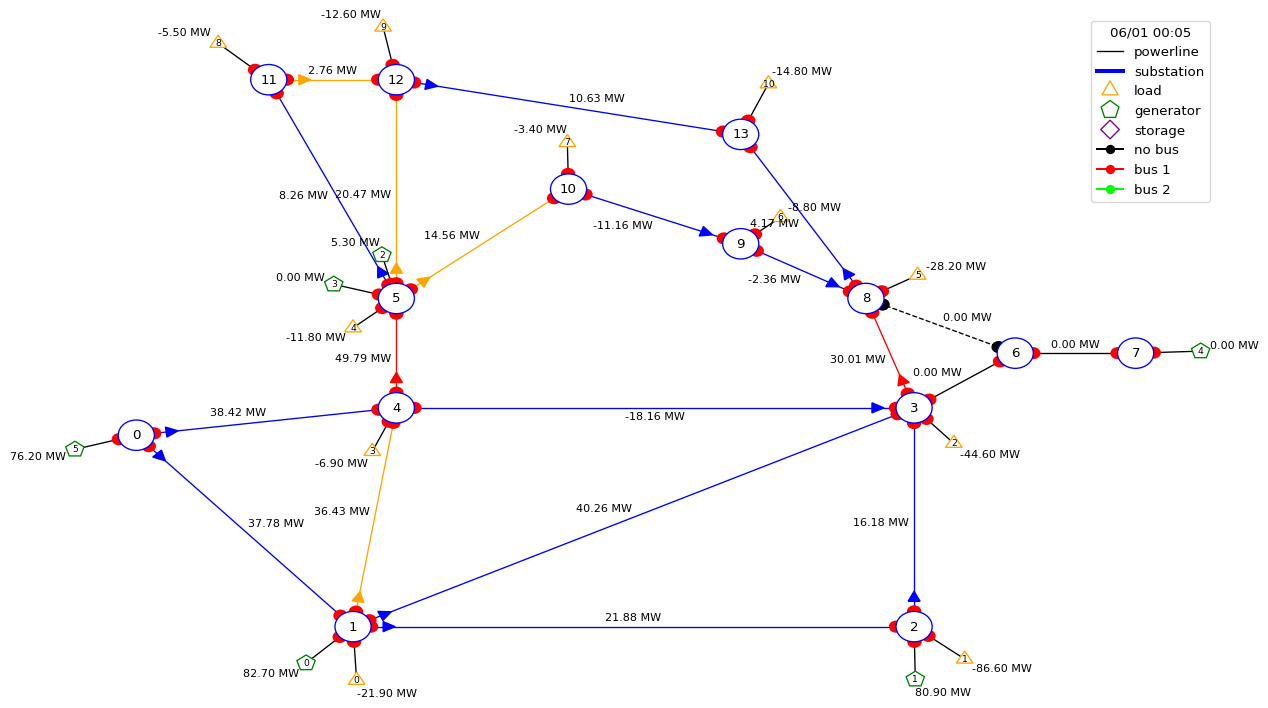

In [172]:
plot_helper = PlotMatplot(env.observation_space)
fig = plot_helper.plot_obs(obs,line_info='p')
fig.show()

In [175]:
np.max(np.abs(por_virtual_N2-obs.p_or))

9.197264468241428e-06

## comparing to real N-K load flow

In [176]:
idls=[3,4,7,14]
#with env.copy() as tmp_env:
obs_NK, *_ = env.simulate(env.action_space({"set_line_status": [(idl, -1) for idl in idls]}))

/tmp/ipykernel_51711/3656808222.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


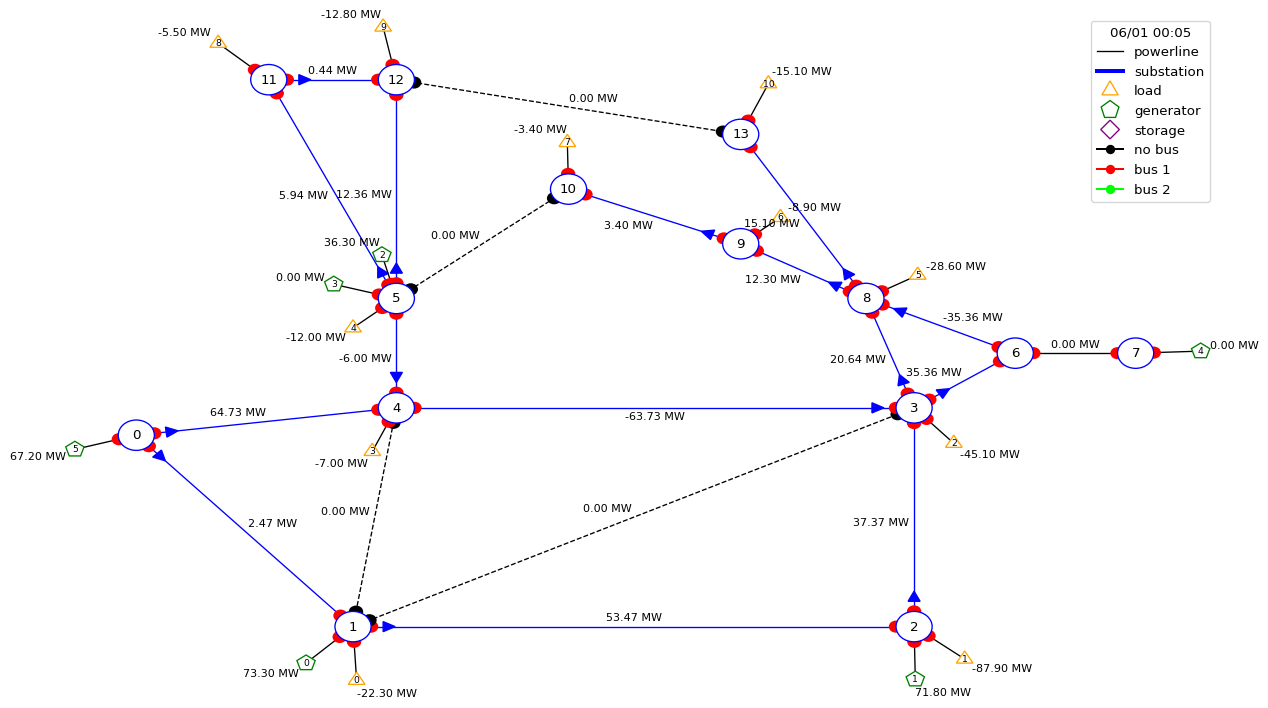

In [177]:
plot_helper = PlotMatplot(env.observation_space)
fig = plot_helper.plot_obs(obs_NK,line_info='p')
fig.show()

In [178]:
init_obs, *_ = env.simulate(env.action_space())
por_init=init_obs.p_or

In [179]:
por_virtual_NK=get_Virtual_Flows_NK(por_init.copy(),A,idls)
por_virtual_NK

[60.27649747 51.85436295 22.26387271 18.50637801]


array([ 2.4671774e+00,  6.4732811e+01,  5.3467201e+01,  5.0102631e-07,
        9.9185957e-07,  3.7367203e+01, -6.3732815e+01, -1.9464713e-07,
        5.9445724e+00,  1.2355430e+01,  1.2299999e+01,  1.5099999e+01,
        3.4000025e+00,  4.4457120e-01,  1.6162043e-07,  3.5362259e+01,
        2.0637732e+01, -6.0000186e+00,  0.0000000e+00, -3.5362259e+01],
      dtype=float32)

In [180]:
np.max(np.abs(por_virtual_NK-obs_NK.p_or))

1.9550323e-05

## Do topological changes now

In [181]:
from sub_elems import get_valid_sub_action

In [182]:
import json
action_dict_file="unitary_actions_l2rpn_2019.json"
with open(action_dict_file) as jsonFile:
    jsonObject = json.load(jsonFile)
    jsonFile.close()

In [183]:
jsonObject

{'sub_4': {'a': {'lines_id_bus': [[4, 2]], 'loads_id_bus': [[3, 2]]},
  'b': {'lines_id_bus': [[4, 2], [6, 2]]},
  'c': {'lines_id_bus': [[1, 2], [17, 2]]},
  'd': {}},
 'sub_3': {'a': {'lines_id_bus': [[6, 2], [16, 2]]},
  'b': {'lines_id_bus': [[6, 2], [15, 2]]},
  'c': {'lines_id_bus': [[16, 2], [5, 2]]},
  'd': {'lines_id_bus': [[16, 2], [5, 2], [6, 2]]},
  'e': {}},
 'sub_1': {'a': {'lines_id_bus': [[0, 2], [4, 2]], 'loads_id_bus': [[0, 2]]},
  'b': {'lines_id_bus': [[0, 2], [4, 2], [2, 2]]},
  'c': {'lines_id_bus': [[0, 2], [3, 2], [4, 2]]},
  'd': {}},
 'sub_8': {'a': {'lines_id_bus': [[19, 2], [10, 2], [11, 2]]},
  'b': {'lines_id_bus': [[16, 2], [11, 2]]},
  'c': {}},
 'sub_5': {'a': {'lines_id_bus': [[17, 2], [9, 2], [7, 2]]}, 'b': {}}}

### Check correctness by doing N-2 somehow with one N-1 and one topological change

#### Apply first topological change and compute virtual flow from virtual line that will be dispatched by node splitting

In [184]:
sub_id=4
action_1_def={sub_id:{'lines_id_bus': [[4, 2], [6, 2]]}}
#action_1_def={sub_id:{'lines_id_bus': [[4, 2]]}}
action1=get_valid_sub_action(env.action_space,action_1_def)

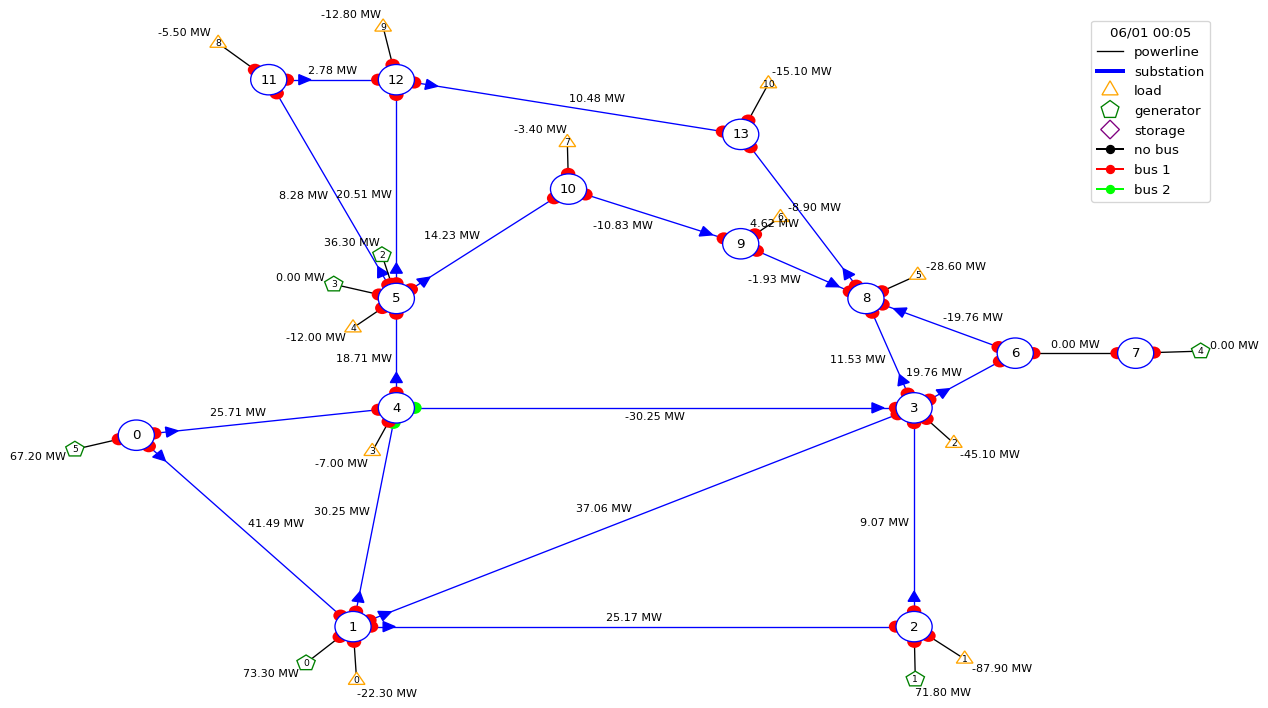

In [185]:
#obs = env.reset()
obs, reward, done, info = env.simulate(env.action_space(action1))
fig_obs = plot_helper.plot_obs(obs, line_info='p')

In [186]:
env.name_line

array(['0_1_0', '0_4_1', '1_2_2', '1_3_3', '1_4_4', '2_3_5', '3_4_6',
       '5_10_7', '5_11_8', '5_12_9', '8_9_10', '8_13_11', '9_10_12',
       '11_12_13', '12_13_14', '3_6_15', '3_8_16', '4_5_17', '6_7_18',
       '6_8_19'], dtype='<U8')

In [187]:
obs_init, reward, done, info = env.simulate(env.action_space({}))

/tmp/ipykernel_51711/939299483.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


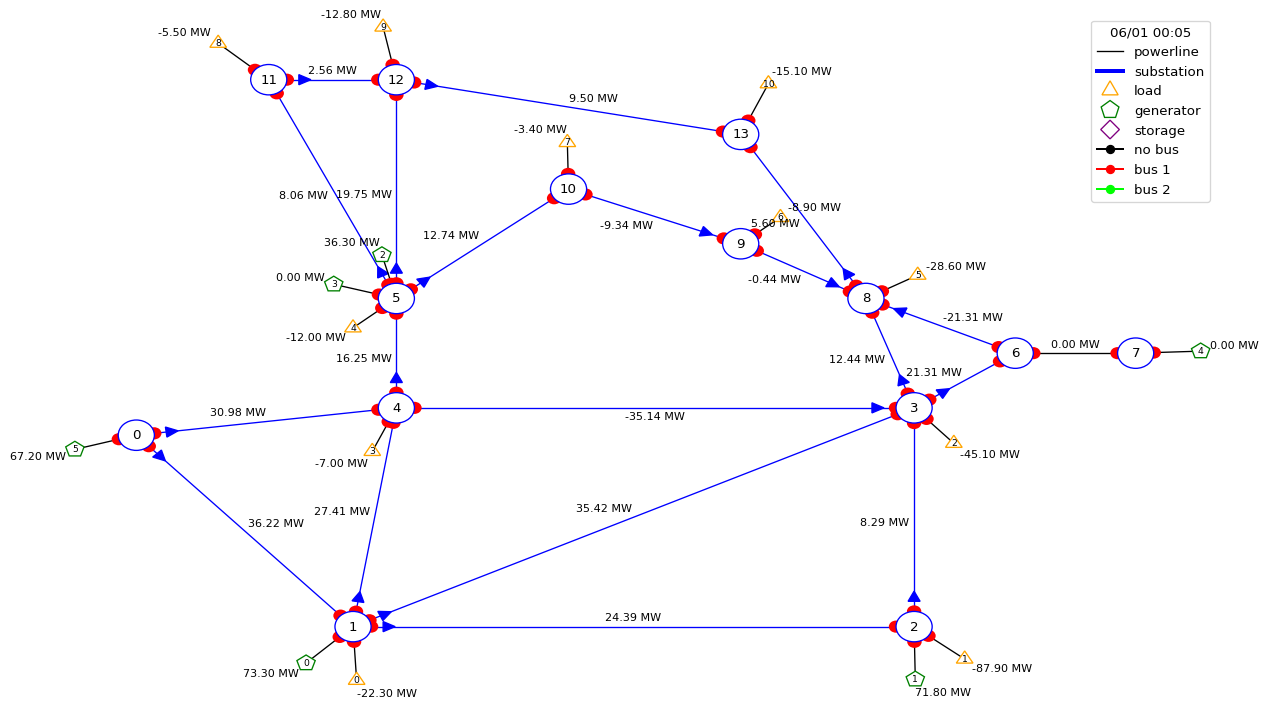

In [188]:
plot_helper = PlotMatplot(env.observation_space)
fig = plot_helper.plot_obs(obs_init,line_info='p')
fig.show()

In [189]:
delta_flow=obs.p_or-obs_init.p_or
delta_flow

array([ 5.264633  , -5.264633  ,  0.78263664,  1.6378899 ,  2.8441048 ,
        0.7826376 ,  4.8857784 ,  1.4845161 ,  0.21803665,  0.7626991 ,
       -1.4845166 , -0.9807348 , -1.4845171 ,  0.21803594,  0.9807348 ,
       -1.5567303 , -0.90852165,  2.465252  ,  0.        ,  1.5567303 ],
      dtype=float32)

In [192]:
a=[]
ilds=[1,17,4,6]
for idl in ilds:
    a_row=[A[idlj][idl] for idlj in ilds]
    a.append(a_row)
a=np.array(a)
b=np.array([delta_flow[idl] for idl in ilds])
print(b)
pls_virtual=np.linalg.solve(a,b)
print(pls_virtual)

[-5.264633   2.465252   2.8441048  4.8857784]
[13.10139725 -6.33600565 10.17903249 13.07156274]


In [193]:
delta_flow_recomputed=np.zeros(20)
for i in range(len(ilds)):
    delta_flow_recomputed+= A[ilds[i]]*pls_virtual[i]

In [194]:
delta_flow_recomputed

array([ 5.2646313 , -5.26463318,  0.78263564,  1.6378902 ,  2.84410477,
        0.78263564,  4.88577843,  1.48451617,  0.21803595,  0.7626992 ,
       -1.48451614, -0.98073447, -1.48451625,  0.21803582,  0.98073464,
       -1.55672959, -0.90852195,  2.46525192,  0.        ,  1.55672959])

In [196]:
delta_flow_action=5.56
delta_flow_0_4+delta_flow_4_5

NameError: name 'delta_flow_0_4' is not defined

In [38]:
#flow_mat, (load, prod, stor, ind_lor, ind_lex) = init_obs.flow_bus_matrix()

In [152]:
#from cvxopt import matrix, solvers
#!pip install --trusted-host pypi.python.org cvxopt

## try pseudo inverse

In [197]:
ilds=[1,17,4,6]
ilds_node1=[1,17]
ilds_node2=[4,6]

In [198]:
#AX=[alpha,-(5.56-alpha),-beta,-5.56+beta]

a_augmented=[]

last_coeff=[[-1,0],[-1,0],[0,1],[0,-1]]
b=[0,-5.56,0,-5.56]#,-5.56]
for i in range(len(ilds)):
    a_row=[A[idlj][ilds[i]] for idlj in ilds]
    a_row+=last_coeff[i]
    #a_row=np.array(a_row)
    a_augmented.append(a_row)
    
#adding constraint that on the virtual line we should have -5.56 
#(42.09-(5.56))/37.62=0.971 for line 1 => np.sum(A[1][ilds_node2])
#(-28.55-(5.56))/36.28=-0.94 for line 17 => np.sum(A[17][ilds_node2])
#(-8.34-(5.56))/35.12=-0.396 for line 4 => np.sum(A[4][ilds_node2])
#(21.21-(5.56))/-29.56=-0.53 for line 6 => -np.sum(A[6][ilds_node2])

#a_row=[np.sum(A[idlj][ilds_node2]) for idlj in ilds]
#a_row+=[0,0]
#a_row=np.array(a_row)
#a_augmented.append(a_row)
a=np.array(a)

pinv=np.linalg.pinv(a_augmented)

In [199]:
#AX=[alpha,-(5.56-alpha),-beta,-5.56+beta]

#a_augmented=[]
#
#last_coeff=[[0],[0],[-1],[-1]]
#b=[3.7860374,-1.7728767,0,-5.56]#,-5.56]
#for i in range(len(ilds)):
#    a_row=[A[idlj][ilds[i]] for idlj in ilds]
#    a_row+=last_coeff[i]
#    #a_row=np.array(a_row)
#    a_augmented.append(a_row)
#    
##adding constraint that on the virtual line we should have -5.56 
##(42.09-(5.56))/37.62=0.971 for line 1 => np.sum(A[1][ilds_node2])
##(-28.55-(5.56))/36.28=-0.94 for line 17 => np.sum(A[17][ilds_node2])
##(-8.34-(5.56))/35.12=-0.396 for line 4 => np.sum(A[4][ilds_node2])
##(21.21-(5.56))/-29.56=-0.53 for line 6 => -np.sum(A[6][ilds_node2])
#
##a_row=[np.sum(A[idlj][ilds_node2]) for idlj in ilds]
##a_row+=[0,0]
##a_row=np.array(a_row)
##a_augmented.append(a_row)
#a=np.array(a)
#
#pinv=np.linalg.pinv(a_augmented)

In [200]:
#array([ 3.7860374, -1.7728767, -2.0453262, -3.513586 ] true values
x = pinv.dot(b)#[-1.98257326  4.19641916 -0.60737363 -0.13390695  1.47436056  0.80934757]
print(x)

[-1.98257326  4.19641916 -0.60737363 -0.13390695  1.47436056  0.80934757]


In [201]:
a.dot(x[0:4])

array([ 1.47436057, -4.08563944, -0.80934758, -4.75065243])

In [202]:
obs_init.p_or[4]+-0.80934758 #obs_init.p_or[4]-beta+obs_init.p_or[6]

26.600799133256835

In [203]:
obs_init.p_or[6]+-4.75065243

-39.890682337226565

In [204]:
obs_init.p_or[1]+1.47436057

32.452355488823244

In [205]:
obs_init.p_or[17]-4.08563944

12.162470377504883

In [206]:
obs_init.p_or[4]+-2.56#-2.0453262

24.850146713256837

In [207]:
obs_init.p_or[6]+-3#-3.513586

-38.14002990722656

In [208]:
obs_init.p_or[1]+3.7860374

34.76403231882324

In [209]:
obs_init.p_or[17]-1.7728767

14.475233117504883

In [210]:
delta_flow_recomputed=np.zeros(20)
for i in range(len(ilds)):
    delta_flow_recomputed+= A[ilds[i]]*x[i]

In [211]:
delta_flow_recomputed

array([-1.47436033,  1.47436057, -0.21502054, -0.44999218, -0.80934758,
       -0.21502054, -4.75065243, -2.46027628, -0.36134897, -1.26401406,
        2.46027622,  1.62536303,  2.46027633, -0.36134897, -1.62536305,
        2.57995438,  1.50568496, -4.08563944,  0.        , -2.57995438])

In [212]:
#sub_id=4
#sign_sum=[1 if env.line_or_to_subid[idl]==sub_id else -1 for idl in ilds]
#sign_sum

### Resistance Matrix

#### R_eq computation

In [213]:
import pandapower as pp
net=env.backend._grid
pp.rundcpp(net)
Bbus_pypower=net._ppc["internal"]["Bbus"].todense().real#["Ybus"]
Bbus_pypower

numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)



AttributeError: 'lightsim2grid_cpp.GridModel' object has no attribute '_options'

In [214]:
ppc_indices = net._pd2ppc_lookups["bus"][[i for i in range(14)]]
Bbus_pp=Bbus_pypower[ppc_indices,:]#changes rows
Bbus_pp=Bbus_pp[:,ppc_indices]#change colums
Bbus_pp

AttributeError: 'lightsim2grid_cpp.GridModel' object has no attribute '_pd2ppc_lookups'

In [ ]:
env.name_line

In [215]:
env.name_line
env.backend._grid.line["x_ohm_per_km"]

AttributeError: 'lightsim2grid_cpp.GridModel' object has no attribute 'line'

In [216]:
1/11.268335

0.08874425547341289

In [534]:
-Bbus_pp[0,1]

16.900456312320433

In [385]:
pinv_Bbus=np.linalg.pinv(Bbus_pp)

In [390]:
#Rij=L†ii + L†jj − 2L†ij 
pinv_Bbus=np.linalg.pinv(Bbus_pp)
n_nodes=pinv_Bbus.shape[0]
R_eq=[[pinv_Bbus[i,i]+pinv_Bbus[j,j]-2*pinv_Bbus[i,j] for i in range(n_nodes)] for j in range(n_nodes)]

#### R_eq manipulation and update

In [442]:
def get_paralell_R(R_eq_i_j,w_ij,i,j):
    #w_ij=1/-Bbus[i,j]
    R_paralell=R_eq_i_j*w_ij/(w_ij-R_eq_i_j)
    return R_paralell

In [493]:
#deleting edje (i,j) Ωxy + ((Ωxj −Ωxi) − (Ωjy −Ωiy))^2/ 4(ωij−Ωij )
def Req_Update_edge_delete(R_eq,Bbus,x,y,i,j):
    #x,y edge of interest
    #i,j edge deleted
    w_ij=1/-Bbus[i,j]
    Req_update=(R_eq[x][y])+((R_eq[x][j]-R_eq[x][i])-(R_eq[j][y]-R_eq[i][y]))**2/(4*(w_ij-R_eq[i][j]))
    return Req_update

#### R_eq checking

For line 6-7, the Req is obvious as there is a single path

In [516]:
print(R_eq[6][7])
1/Bbus_pp[6,7]

0.17614999999999975


-0.17614999999999997

In [519]:
print(np.array(R_eq[6])-np.array(R_eq[7]))

[-0.17615 -0.17615 -0.17615 -0.17615 -0.17615 -0.17615 -0.17615  0.17615
 -0.17615 -0.17615 -0.17615 -0.17615 -0.17615 -0.17615]


For line 0-4, if deleting line 0-1, the Req is obvious as there is a single path (and conversely)

In [524]:
x=0
y=4

i=0
j=1

print(Req_Update_edge_delete(R_eq,Bbus_pp,x,y,i,j))
-1/Bbus_pp[x,y]

0.22304000000000174


0.22304000000000002

In [525]:
x=0
y=1

i=0
j=4

print(Req_Update_edge_delete(R_eq,Bbus_pp,x,y,i,j))
-1/Bbus_pp[x,y]

0.05917000000000013


0.05917

if deleting line 4-5, the Req is the sum of Req_3 + Req_3-8+Req_8

In [527]:
x=0
y=10

i=4
j=5


print(Req_Update_edge_delete(R_eq,Bbus_pp,x,y,i,j))
print(Req_Update_edge_delete(R_eq,Bbus_pp,x,3,i,j))
print(Req_Update_edge_delete(R_eq,Bbus_pp,3,8,i,j))
print(Req_Update_edge_delete(R_eq,Bbus_pp,8,y,i,j))

0.5071725208773611
0.09598660504551795
0.19861553100693655
0.21257038482490692


In [528]:
Req_Update_edge_delete(R_eq,Bbus_pp,x,3,i,j)+Req_Update_edge_delete(R_eq,Bbus_pp,3,8,i,j)+Req_Update_edge_delete(R_eq,Bbus_pp,8,y,i,j)

0.5071725208773614

In [509]:
#check Req computation by load flow
flow_mat, (load, prod, stor, ind_lor, ind_lex) = init_obs.flow_bus_matrix()
injections=np.diag(flow_mat)


In [510]:
np.array(R_eq).dot(injections)

array([-25.40571743, -20.72320889, -11.55377285,  -5.91197198,
        -8.42168021,   8.98008126,   5.62595634,   6.03990908,
        11.69395299,  12.77714154,  11.69443866,  12.89213609,
        13.37382443,  17.16381301])

In [513]:
print(R_eq[0][1])
1/Bbus_pp[0,1]

0.049585563497863416


-0.05917

In [514]:
print(R_eq[0][4])
1/Bbus_pp[0,4]

0.08685509921183387


-0.22304000000000002

In [520]:
1/Bbus_pp[1,4]

-0.17388

In [404]:
#array([ 3.7860374, -1.7728767, -2.0453262, -3.513586 ]
print(R_eq[4][5])
print(R_eq[0][4])

#1.77/3.78
#0.08685509921183387/0.16184222873853787

0.16184222873853787
0.08685509921183387


#### R_eq manual nodal computation for topological change

In [ ]:
#for node 2(line 1-4 and 3-4) to node 1
# to go to node 1 by line 0-4
# R11 line 3-4 => sub 1 (thorugh line 3-1 and line 3-2 => 2-1)
#                                                         =>  R13 line 1-0 => line 0-4
# R12 line 4-1 => sub1

# R21 line 4-1 => sub3 (thorugh line 3-1 and line 3-2 => 2-1)
#                                                        => R23 sub5 (through distribution grid) => line 4-5
# R22 line 3-4 => sub3 

In [539]:
w01=-1/Bbus_pp[0,1]
w04=-1/Bbus_pp[0,4]
w14=-1/Bbus_pp[1,4]
w34=-1/Bbus_pp[3,4]
w32=-1/Bbus_pp[3,2]
w12=-1/Bbus_pp[1,2]
w31=-1/Bbus_pp[1,3]
w45=-1/Bbus_pp[4,5]
w123=w12+w32

In [536]:
R12=w14
R22=w34
R123=w123*w31/(w31+w123)

In [540]:
R11=w34+R123
R13=w01+w04
R1=R11*R12/(R12+R11)+R13
R1

0.3659192199957916

In [541]:
R21=w14+R123
R23=Req_Update_edge_delete(R_eq,Bbus_pp,3,5,4,5)+w45
R2=R21*R22/(R22+R21)+R23
R2

0.7566365156633286

In [544]:
0.3659/0.7566

0.4836108908273856

In [543]:
R_node1_node2=R1*R2/(R1+R2)
R_node1_node2

0.2466406208946881

In [ ]:
#for node 1(line 0-4 and 4-5) to node 2
# to go to node 2 by line &-4
# R11 line 4-5 => R13 sub3 (through distribution grid) => R123 sub 1 (thorugh line 3-1 and line 3-2 => 2-1)
#                                                                                                      => line 1-4
# R12 line 4-0 => line 0-1 

# R21 line 4-0 => line 0-1 => R23 sub 1 (thorugh line 3-1 and line 3-2 => 2-1)
#                                                                             => line 3-4
# R22 line 4-5 => R24 sub3 (through distribution grid)

In [545]:
R13=Req_Update_edge_delete(R_eq,Bbus_pp,3,5,4,5)
R123=w123*w31/(w31+w123)
R11=w45+R13+R123
R12=w01+w04

R1=R11*R12/(R11+R12)+w14
R1

0.38506529688181934

In [546]:
R21=R12+R123
R22=w45+R13
R2=R21*R22/(R21+R22)+w34
R2

0.299856424848389

#### R_eq manual nodal systematic for topological change

In [487]:
i=4
j=5

x=0
y=4

w_xy=1/-Bbus_pp[x,y]
print(w_xy)
w_ij=1/-Bbus_pp[i,j]
print(w_ij)
R_eq_xy=R_eq[x][y]
print(R_eq_xy)

R_eq_04_delete_45=Req_Update_edge_delete(R_eq,Bbus_pp,x,y,i,j)
print(R_eq_04_delete_45)

R_eq_node1_node2_sub0=get_paralell_R(R_eq_04_delete_45,w_xy,x,y)+w_xy
print(R_eq_node1_node2_sub0)


0.22304000000000002
0.23488264000000003
0.08685509921183387
0.08708966210692048
0.36591921999579186


In [488]:
i=0
j=4

x=4
y=5

w_xy=1/-Bbus_pp[x,y]
print(w_xy)
w_ij=1/-Bbus_pp[i,j]
print(w_ij)
R_eq_xy=R_eq[x][y]
print(R_eq_xy)

R_eq_45_delete_04=Req_Update_edge_delete(R_eq,Bbus_pp,x,y,i,j)
print(R_eq_45_delete_04)

R_eq_node1_node2_sub5=get_paralell_R(R_eq_45_delete_04,w_xy,x,y)+w_xy
print(R_eq_node1_node2_sub5)


0.23488264000000003
0.22304000000000002
0.16184222873853787
0.161968032482012
0.7566365156633287


In [447]:
#0.3653001868919218/0.7553735954179829
#=> 0.483
#vs 1.77/3.78
#=> 0.468

0.4836020071495674

In [498]:
i=1
j=4

x=4
y=3

w_xy=1/-Bbus_pp[x,y]
print(w_xy)
w_ij=1/-Bbus_pp[i,j]
print(w_ij)
R_eq_xy=R_eq[x][y]
print(R_eq_xy)

R_eq_34_delete_14=Req_Update_edge_delete(R_eq,Bbus_pp,x,y,i,j)
print(R_eq_34_delete_14)

R_parallel=get_paralell_R(R_eq_34_delete_14,w_xy,x,y)
print(R_parallel)
R_eq_node1_node2_sub3=R_parallel+w_xy
print(R_eq_node1_node2_sub3)


0.04211
0.17388
0.033848042692293995
0.036196329479528166
0.2577464248483896
0.2998564248483896


In [499]:
#env.name_line
#env.backend._grid.line["x_ohm_per_km"]

In [500]:
x=4
y=1

i=3
j=4

w_xy=1/-Bbus_pp[x,y]
print(w_xy)
w_ij=1/-Bbus_pp[i,j]
print(w_ij)
R_eq_xy=R_eq[x][y]
print(R_eq_xy)

R_eq_14_delete_34=Req_Update_edge_delete(R_eq,Bbus_pp,x,y,i,j)
print(R_eq_14_delete_34)

R_parallel=get_paralell_R(R_eq_14_delete_34,w_xy,x,y)
print(R_parallel)
R_eq_node1_node2_sub1=R_parallel+w_xy
print(R_eq_node1_node2_sub1)


0.17388
0.04211
0.06418402193104036
0.09536278579027792
0.21118529688181886
0.3850652968818189


In [452]:
#0.2998/0.38506
#=>0.778
#2.04/3.51
#=>0.581

0.5811965811965812

numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)

<ipython-input-86-1d7851251705>:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


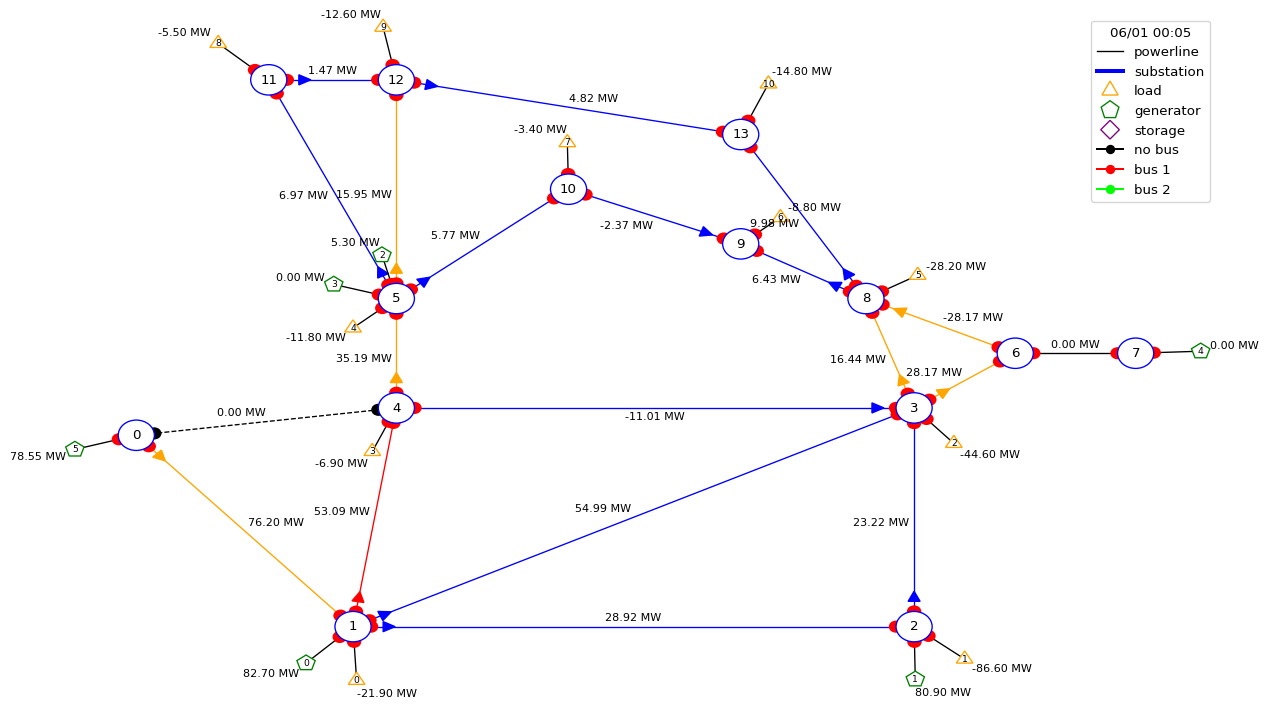

In [86]:
obs_l1, *_ = env.simulate(env.action_space({"set_line_status": [(1, -1)]}))
fig = plot_helper.plot_obs(obs_l1,line_info='p')
fig.show()

numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)

<ipython-input-87-266dfcbc7f9c>:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


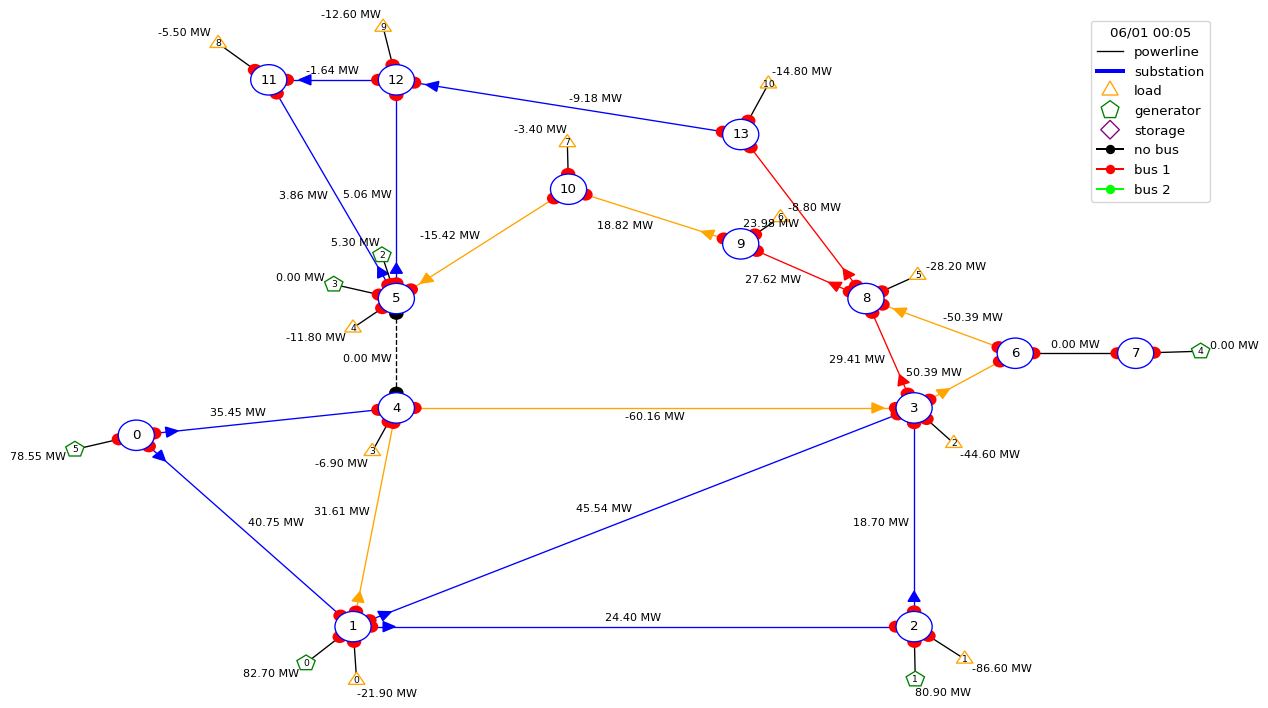

In [87]:
obs_l17, *_ = env.simulate(env.action_space({"set_line_status": [(17, -1)]}))
fig = plot_helper.plot_obs(obs_l17,line_info='p')
fig.show()

numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)

<ipython-input-243-1beff1836e98>:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


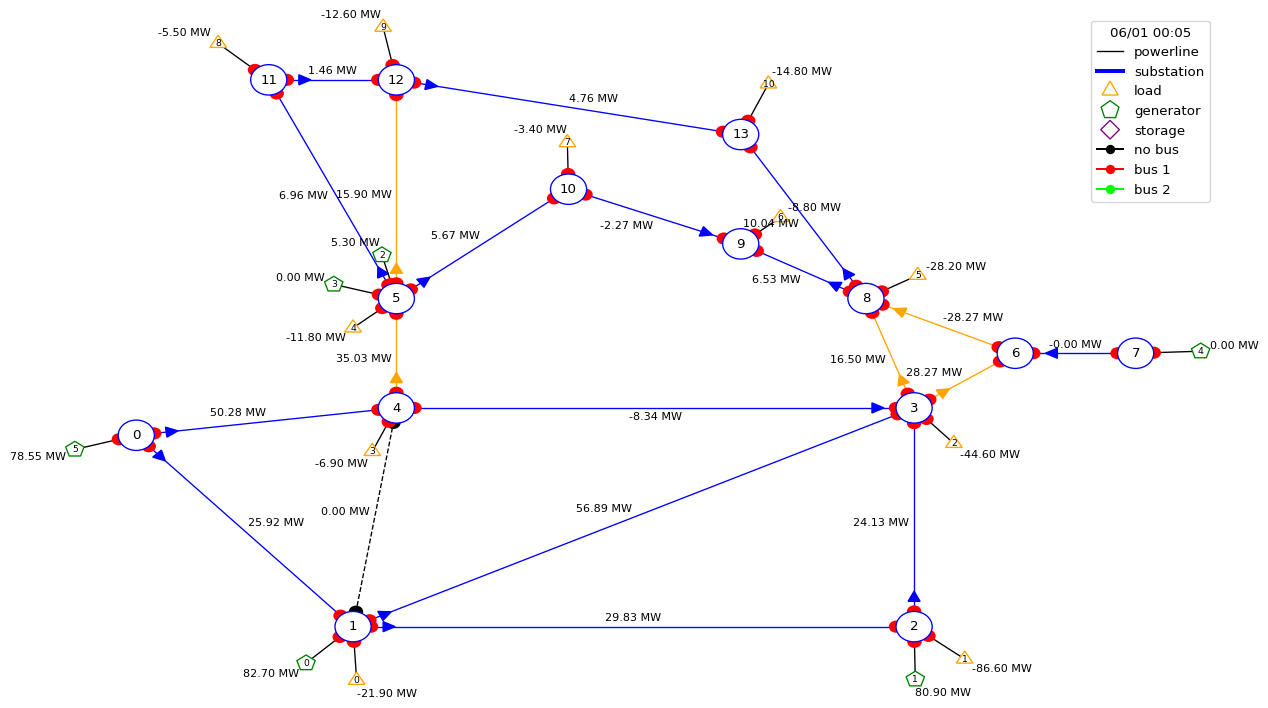

In [243]:
obs_l17, *_ = env.simulate(env.action_space({"set_line_status": [(4, -1)]}))
fig = plot_helper.plot_obs(obs_l17,line_info='p')
fig.show()

numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)

<ipython-input-244-040d12f18a06>:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


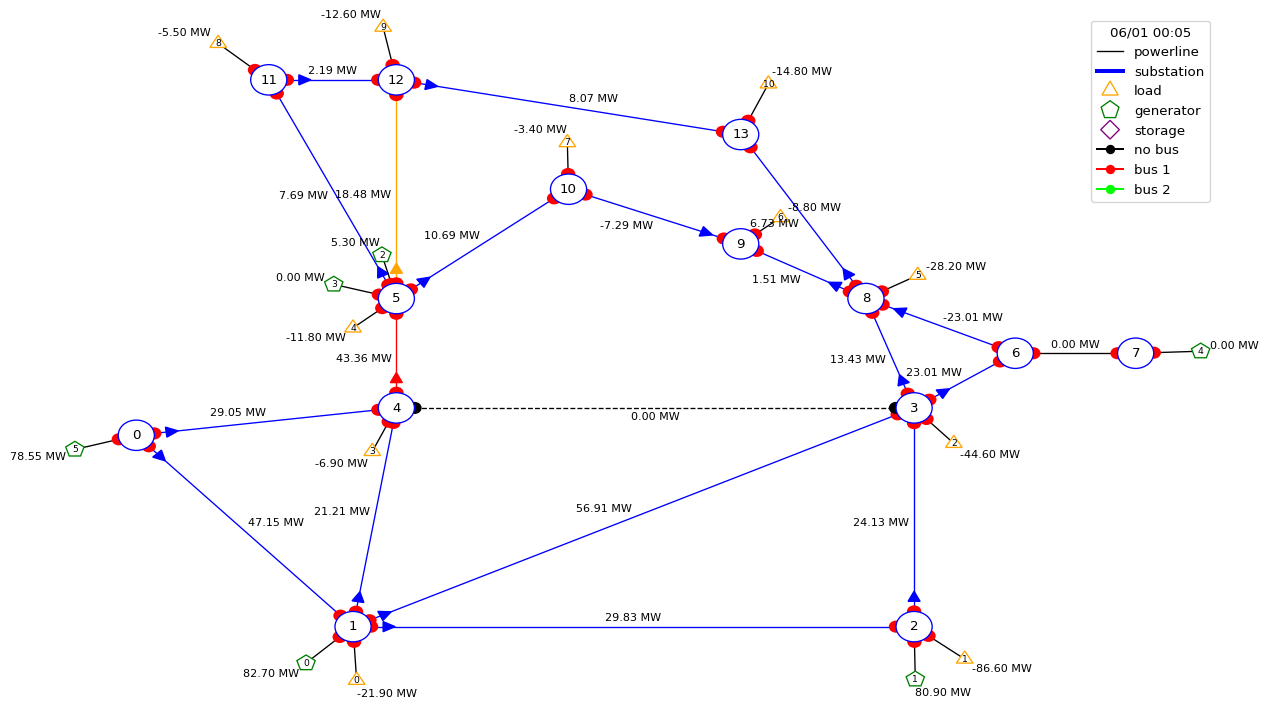

In [244]:
obs_l6, *_ = env.simulate(env.action_space({"set_line_status": [(6, -1)]}))
fig = plot_helper.plot_obs(obs_l6,line_info='p')
fig.show()

In [61]:
InjectionsNode1=[-por_init[i] for i in range(env.n_line) if ind_lor[i]==sub_id]
InjectionsNode1+=[por_init[i] for i in range(env.n_line) if ind_lex[i]==sub_id]
InjectionsNode1+=[-init_obs.load_p[i] for i in range(len(load)) if load[i]==sub_id]
InjectionsNode1+=[init_obs.gen_p[i] for i in range(len(prod)) if prod[i]==sub_id]
InjectionsNode1

[-36.275322, 37.61641, -6.9]

In [64]:
np.sum(InjectionsNode1)

-5.5589128

In [41]:
#sub_id_2=14
#InjectionsNode2=[-por_init[i] for i in range(env.n_line) if ind_lor[i]==sub_id_2]
#InjectionsNode2+=[por_init[i] for i in range(env.n_line) if ind_lex[i]==sub_id_2]
#InjectionsNode2+=[-init_obs.load_p[i] for i in range(len(load)) if load[i]==sub_id_2]
#InjectionsNode2+=[init_obs.gen_p[i] for i in range(len(prod)) if prod[i]==sub_id_2]
#InjectionsNode2

In [42]:
virtualFlow=-np.sum(InjectionsNode1)

In [258]:
F_topo = virtualFlow
A_topo=(obs.p_or-por_init)/F_topo#.reshape(-1, 1)
#delta_flow_topo=np.abs(obs.p_or-por_init)/

In [259]:
A_topo

array([-3.6050677e-01,  3.6050671e-01,  2.0676929e-01,  4.3272394e-01,
       -1.0000000e+00,  2.0676929e-01,  6.0414976e-01, -2.1283003e-02,
       -3.1258960e-03, -1.0934554e-02,  2.1283003e-02,  1.4060450e-02,
        2.1283003e-02, -3.1259062e-03, -1.4060450e-02,  2.2318279e-02,
        1.3025146e-02, -3.5343479e-02,  3.1610685e-16, -2.2318279e-02],
      dtype=float32)

In [260]:
#por_init+virtualFlow*A_topo

#### Compute combined N-1 + topological change

In [266]:
def get_A_idl1_virtual_line(A,ind_lor,ind_lex,sub_id):
    A_idl1_virtual_line=[A[idl1][i] for i in range(env.n_line) if ind_lor[i]==sub_id]
    A_idl1_virtual_line+=[-A[idl1][i] for i in range(env.n_line) if ind_lex[i]==sub_id]
    print(A_idl1_virtual_line)
    A_idl1_virtual_line=np.sum(A_idl1_virtual_line)
    print(A_idl1_virtual_line)
    
    return A_idl1_virtual_line

def get_Virtual_Flows_N1_topo(por_init,por_topo,A,idl1,A_topo,ind_lor,ind_lex,sub_id ):
    A_idl1_virtual_line=get_A_idl1_virtual_line(A,ind_lor,ind_lex,sub_id)
   
    a=np.array([[A[idl1][idl1],A[idl2][idl1]],[A[idl1][idl2],A[idl2][idl2]]])
    
    a=np.array([[-1,A_topo[idl1]],[A_idl1_virtual_line,-1]])
    b=np.array([-por_init[idl1],-por_topo])
    #print(a)
    #print(b)
    [pl1_virtual,pl2_virtual]=np.linalg.solve(a,b)
    print(pl1_virtual)
    print(pl2_virtual)
    
    por_virtual=por_init+A[idl1]*pl1_virtual+A_topo*pl2_virtual
    
    return por_virtual

In [267]:
virtualFlow

35.121765

In [269]:
line_action={"set_line_status": [(idl1, -1)]}
act=env.action_space(line_action)
act+=env.action_space(action1)

numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)



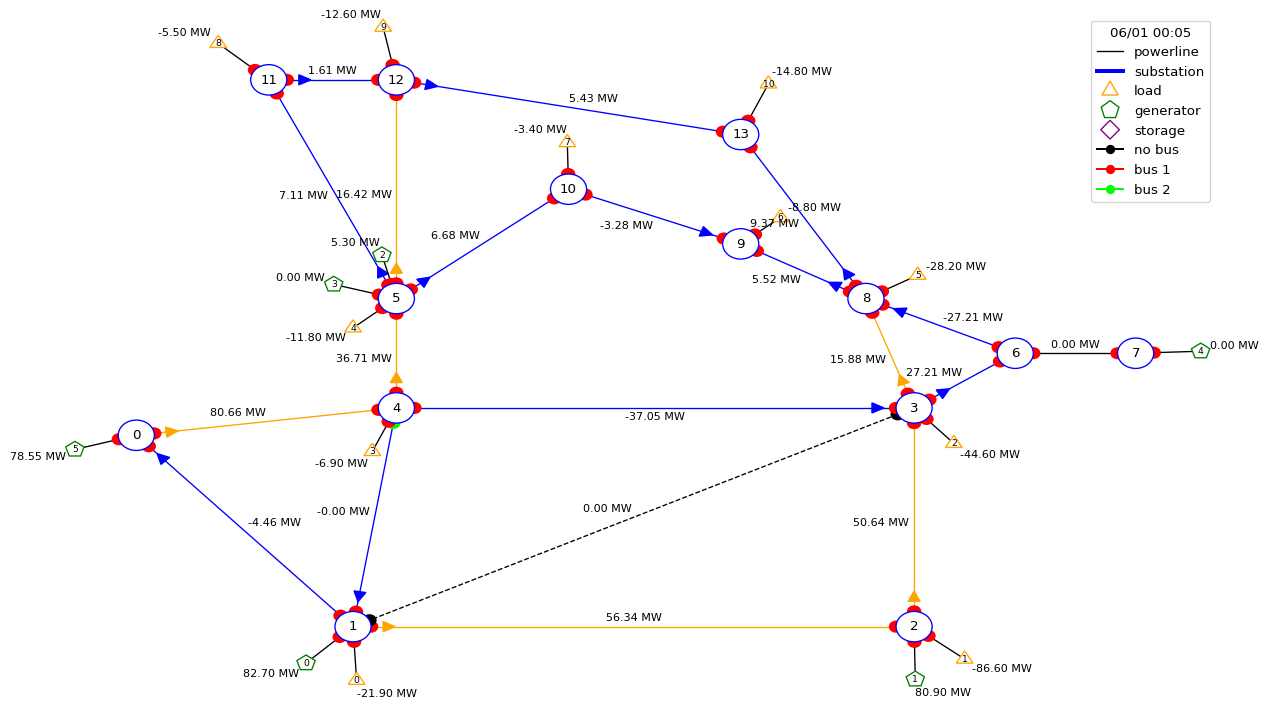

In [270]:
obs_topo_N1, reward, done, info = env.simulate(act)
fig_obs = plot_helper.plot_obs(obs_topo_N1, line_info='p')

In [271]:
idl1=3
por_virtual_topo_N1=get_Virtual_Flows_N1_topo(por_init,virtualFlow,A,idl1,A_topo,ind_lor,ind_lex,sub_id)

[0.03949445921162586, -0.2724346441674472, 0.675105901946444]
0.4421657169906227
70.35573603945282
66.2306596070064


In [272]:
np.max(np.abs(por_virtual_topo_N1-obs_topo_N1.p_or))

3.340496277988436e-06

In [240]:
#can be compared to previous N-2 computation in that case
idl1=3
idl2=4
por_virtual_N2=get_Virtual_Flows_N2(por_init,A,idl1,idl2)

[[-1.          0.43272394]
 [ 0.44216576 -1.        ]]
[-41.696144 -35.121765]
70.35573775031565
66.23066358184452


In [217]:
np.max(np.abs(por_virtual_N2-obs_topo_N1.p_or))

3.554069483158173e-06

### Now try one real bus splitting topological change + N-1

#### Apply first topological change and compute virtual flow from virtual line that will be dispatched by node splitting

In [273]:
sub_id=4
action_1_def={sub_id:{'lines_id_bus': [[4, 2], [6, 2]]}}
#action_1_def={sub_id:{'lines_id_bus': [[4, 2]]}}
action1=get_valid_sub_action(env.action_space,action_1_def)

numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)



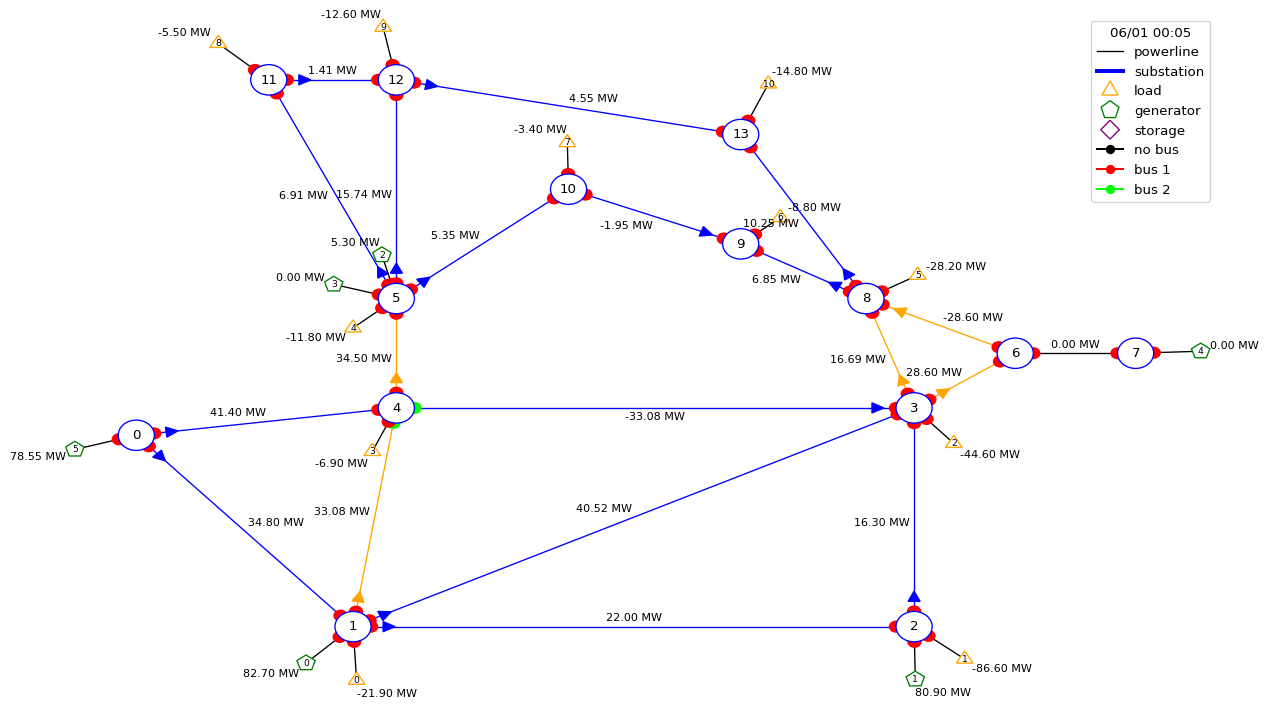

In [274]:
#obs = env.reset()
obs, reward, done, info = env.simulate(env.action_space(action1))
fig_obs = plot_helper.plot_obs(obs, line_info='p')

In [281]:
flow_mat, (load, prod, stor, ind_lor, ind_lex) = obs.flow_bus_matrix()

In [282]:
InjectionsNode1=[-por_init[i] for i in range(env.n_line) if ind_lor[i]==sub_id]
InjectionsNode1+=[por_init[i] for i in range(env.n_line) if ind_lex[i]==sub_id]
InjectionsNode1+=[-init_obs.load_p[i] for i in range(len(load)) if load[i]==sub_id]
InjectionsNode1+=[init_obs.gen_p[i] for i in range(len(prod)) if prod[i]==sub_id]
InjectionsNode1

[-36.275322, 37.61641, -6.9]

In [283]:
np.sum(InjectionsNode1)

-5.5589128

In [284]:
virtualFlow=-np.sum(InjectionsNode1)

In [285]:
F_topo = virtualFlow
A_topo=(obs.p_or-por_init)/F_topo#.reshape(-1, 1)
#delta_flow_topo=np.abs(obs.p_or-por_init)/

In [286]:
A_topo

array([-6.8107516e-01,  6.8107516e-01, -1.0124821e-01, -2.1189024e-01,
       -3.6793637e-01, -1.0124821e-01, -6.3206351e-01, -1.9204898e-01,
       -2.8206831e-02, -9.8668844e-02,  1.9204898e-01,  1.2687567e-01,
        1.9204898e-01, -2.8206874e-02, -1.2687576e-01,  2.0139091e-01,
        1.1753384e-01, -3.1892508e-01,  1.9971946e-15, -2.0139091e-01],
      dtype=float32)

In [287]:
#por_init+virtualFlow*A_topo

#### Compute combined N-1 + topological change

In [288]:
def get_A_idl1_virtual_line(A,ind_lor,ind_lex,sub_id):
    A_idl1_virtual_line=[A[idl1][i] for i in range(env.n_line) if ind_lor[i]==sub_id]
    A_idl1_virtual_line+=[-A[idl1][i] for i in range(env.n_line) if ind_lex[i]==sub_id]
    print(A_idl1_virtual_line)
    A_idl1_virtual_line=np.sum(A_idl1_virtual_line)
    print(A_idl1_virtual_line)
    
    return A_idl1_virtual_line

def get_Virtual_Flows_N1_topo(por_init,por_topo,A,idl1,A_topo,ind_lor,ind_lex,sub_id ):
    A_idl1_virtual_line=get_A_idl1_virtual_line(A,ind_lor,ind_lex,sub_id)
   
    a=np.array([[A[idl1][idl1],A[idl2][idl1]],[A[idl1][idl2],A[idl2][idl2]]])
    
    a=np.array([[-1,A_topo[idl1]],[A_idl1_virtual_line,-1]])
    b=np.array([-por_init[idl1],-por_topo])
    #print(a)
    #print(b)
    [pl1_virtual,pl2_virtual]=np.linalg.solve(a,b)
    print(pl1_virtual)
    print(pl2_virtual)
    
    por_virtual=por_init+A[idl1]*pl1_virtual+A_topo*pl2_virtual
    
    return por_virtual

In [289]:
virtualFlow

5.5589128

In [290]:
line_action={"set_line_status": [(idl1, -1)]}
act=env.action_space(line_action)
act+=env.action_space(action1)

numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)



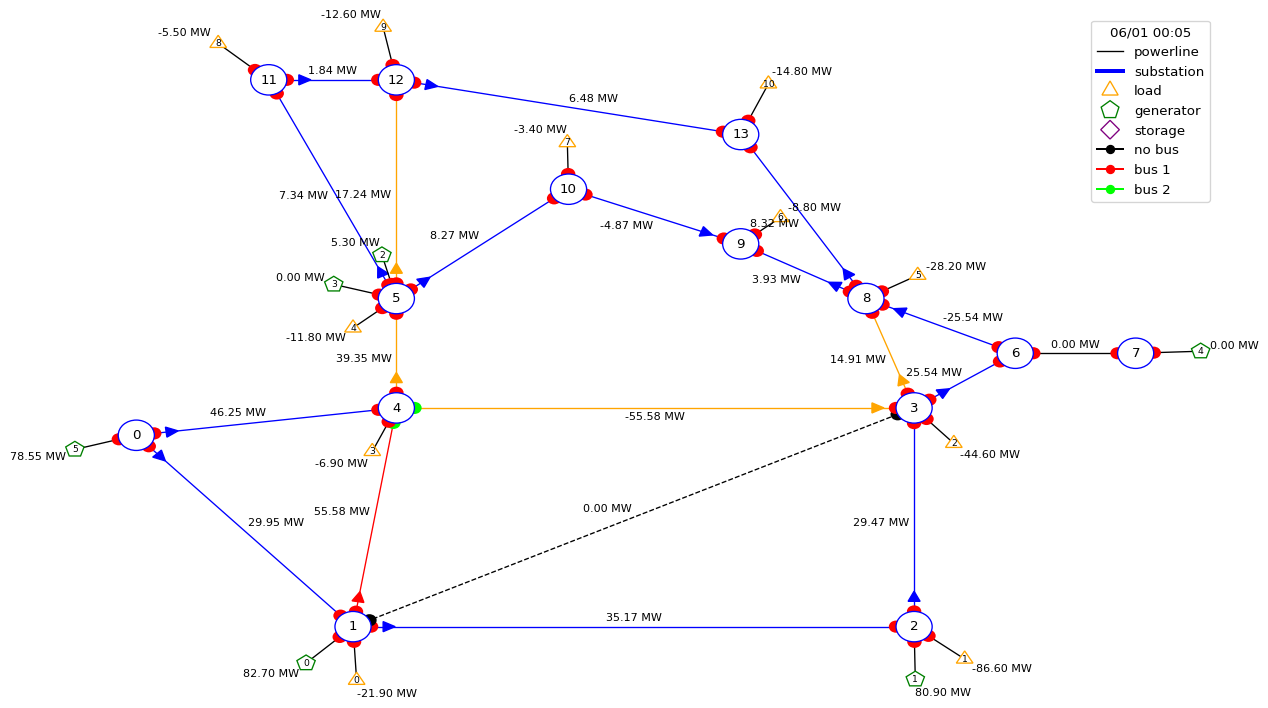

In [291]:
obs_topo_N1, reward, done, info = env.simulate(act)
fig_obs = plot_helper.plot_obs(obs_topo_N1, line_info='p')

In [292]:
idl1=3
por_virtual_topo_N1=get_Virtual_Flows_N1_topo(por_init,virtualFlow,A,idl1,A_topo,ind_lor,ind_lex,sub_id)

[0.03949445921162586, -0.2724346441674472]
-0.23294018495582136
42.62199034307362
-4.369461559641963


In [293]:
np.max(np.abs(por_virtual_topo_N1-obs_topo_N1.p_or))

2.708169205334343e-06